# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

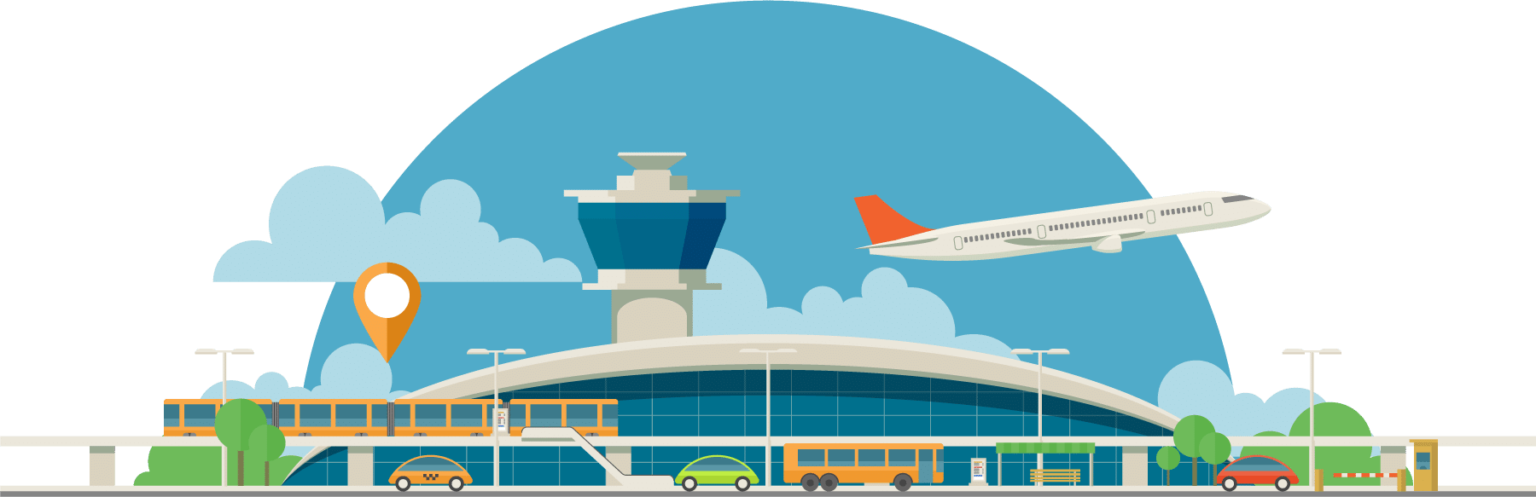

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle
from scipy.stats import uniform, randint

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-08 00:56:40--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-08 00:56:41 (1.18 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

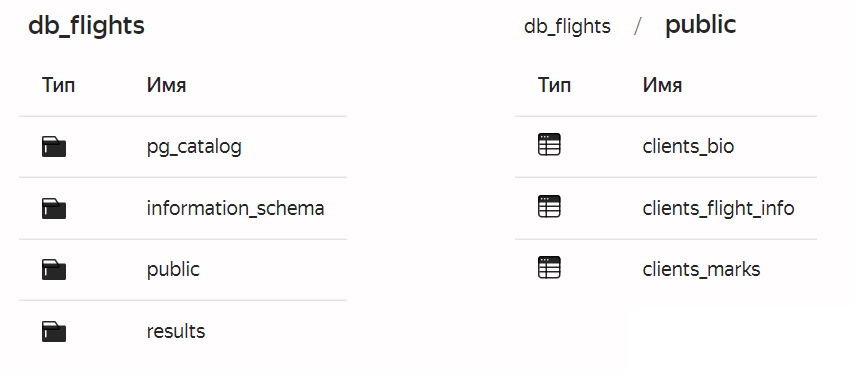



In [4]:
df = None
connection = psycopg2.connect(
    host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    port=6432,
    sslmode='verify-full',
    dbname='db_flights',
    user='mlhs_student',
    password='mlhs_student',
    target_session_attrs='read-write'
)

with connection:
  with connection.cursor() as cursor:
    print("Подключение установлено.")
    # query = "select * from clients_bio;"
    # query = "select * from clients_flight_info;"
    # query = "select * from clients_marks;"
    # query = "SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'clients_marks'"
    # query = "select count(*) from clients_bio;"
    join_sql = """
    SELECT
        bio.id,
        bio.gender,
        bio.age,
        fl_info."Customer Type",
        fl_info."Type of Travel",
        fl_info.class,
        fl_info."Flight Distance",
        fl_info."Departure Delay in Minutes",
        fl_info."Arrival Delay in Minutes",
        marks."Inflight wifi service",
        marks."Departure/Arrival time convenient",
        marks."Ease of Online booking",
        marks."Gate location",
        marks."Food and drink",
        marks."Online boarding",
        marks."Seat comfort",
        marks."Inflight entertainment",
        marks."On-board service",
        marks."Leg room service",
        marks."Baggage handling",
        marks."Checkin service",
        marks."Inflight service",
        marks.cleanliness,
        marks.satisfaction
    FROM
        clients_bio AS bio
    INNER JOIN
        clients_flight_info AS fl_info
        ON bio.id = fl_info.id
    INNER JOIN
        clients_marks AS marks
        ON bio.id = marks.id;
    """


    cursor.execute(join_sql)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]

    df = pd.DataFrame(results, columns=columns)
    df.set_index('id', inplace=True)

df.head()

Подключение установлено.


gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [5]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [ ]:
# DELETE

df['cleanliness'].unique()

array([ 4.,  5.,  1.,  2.,  3.,  0., nan, 45., 15., 10.,  9., 16., 32.,
       18., 12., 35.,  7., 28., 30., 21., 40.,  6.])

In [ ]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [5]:
columns_to_convert_as_float = [
    'age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'cleanliness'
]

df[columns_to_convert_as_float] = df[columns_to_convert_as_float].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

Пропуски имеются.

In [8]:
missing_values = df.isnull().sum()
missing_values

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

In [ ]:
print(df.shape)

(129549, 23)


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

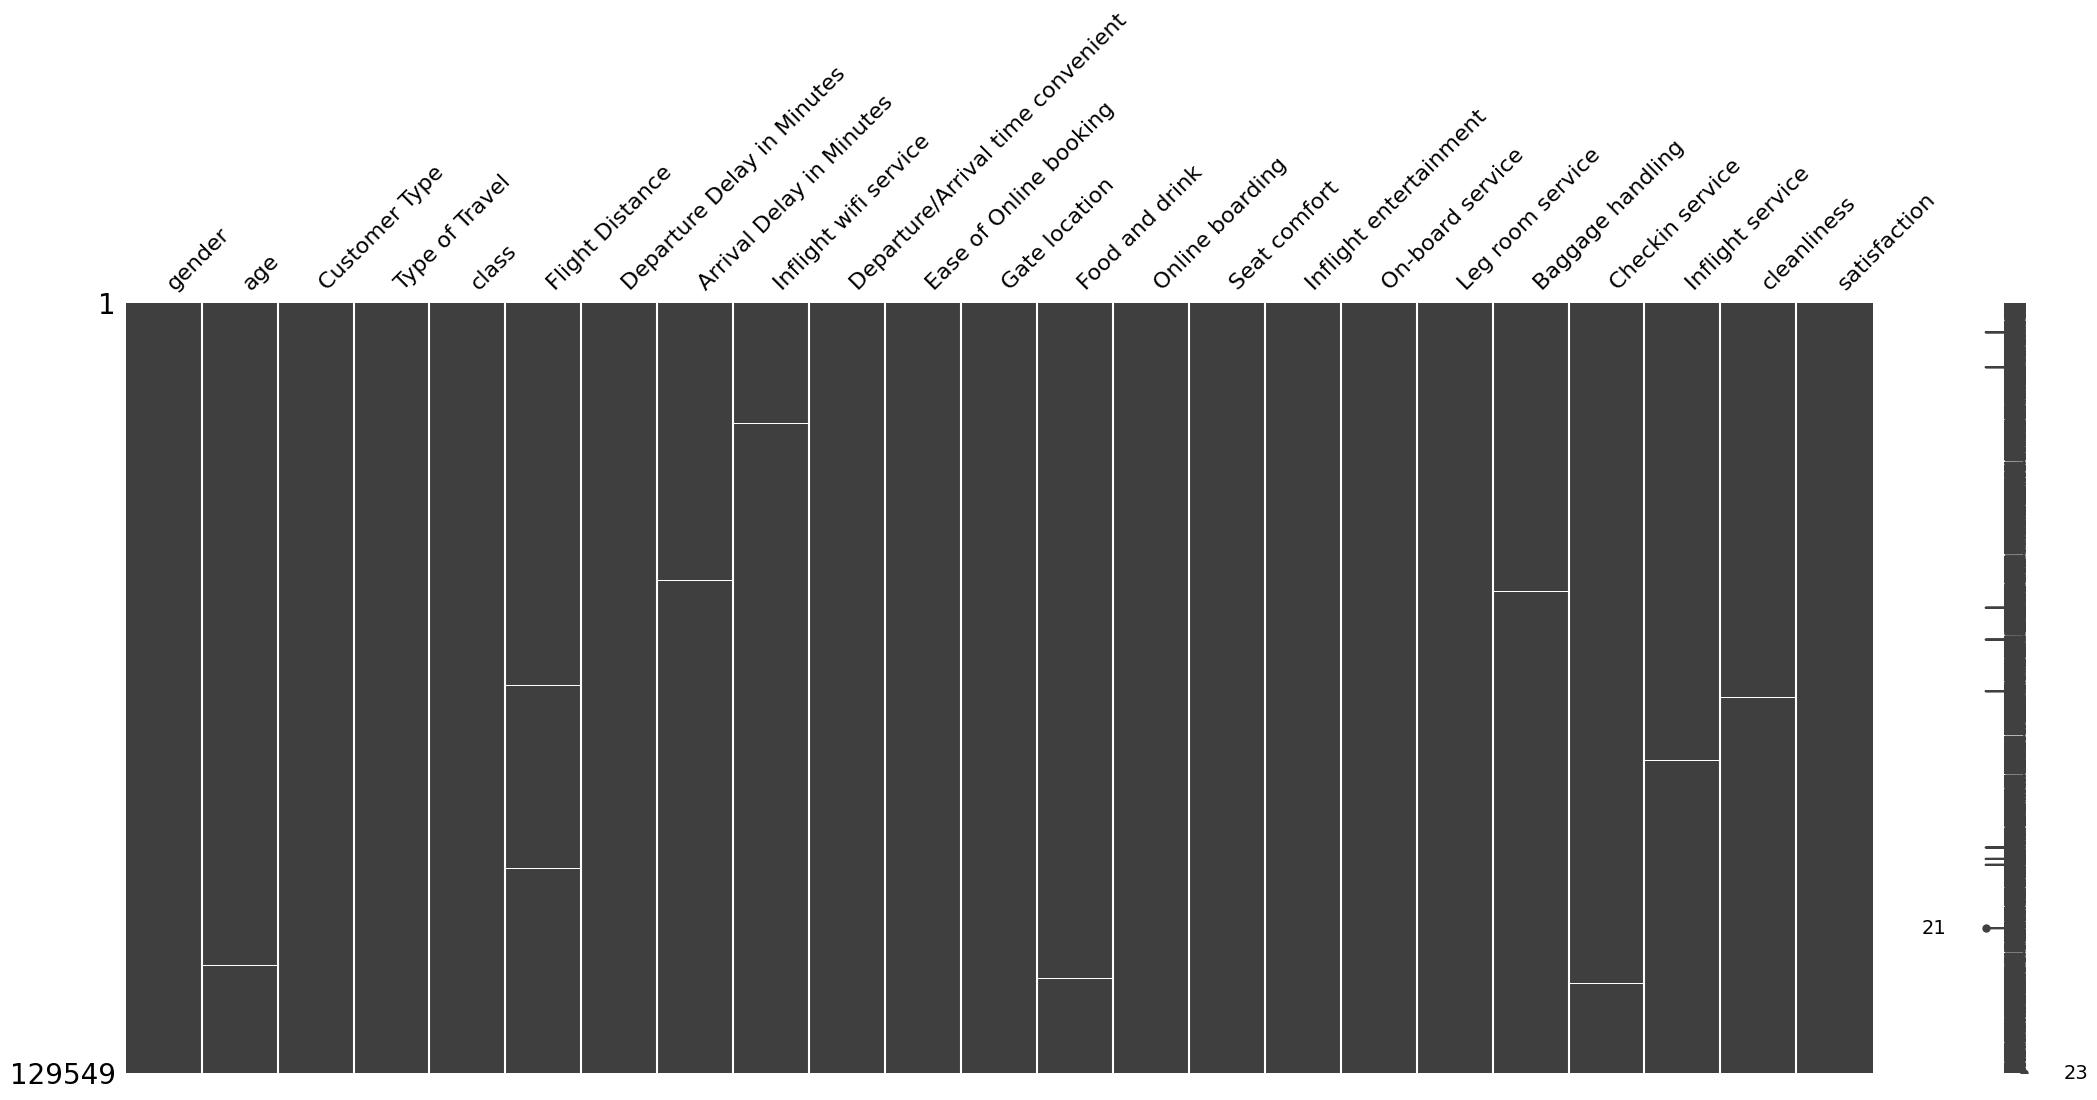

In [ ]:
missingno.matrix(df)

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

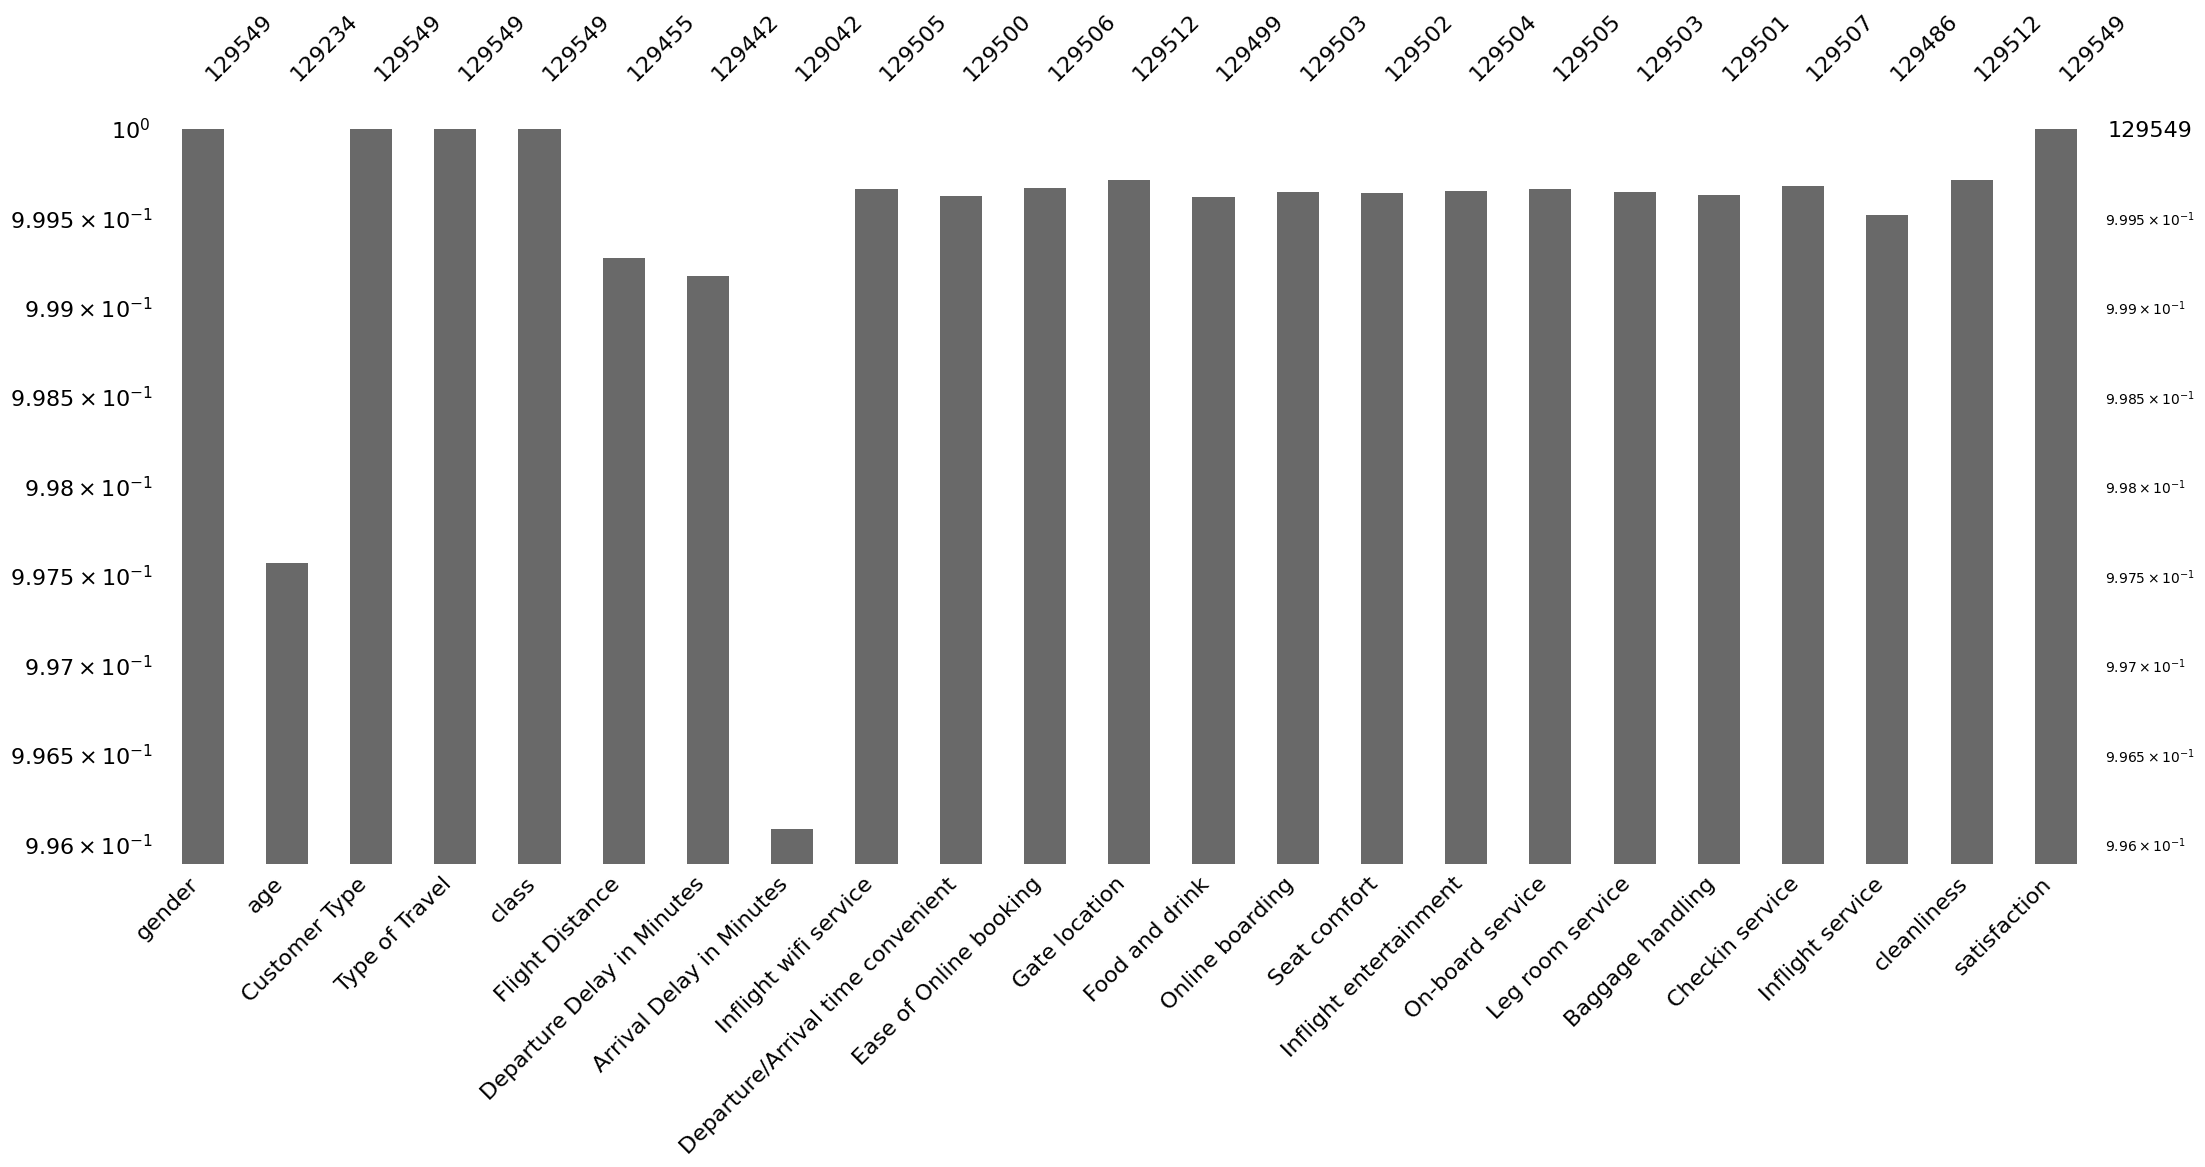

In [ ]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [6]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [ ]:
assert df_train.shape == (103_644, 23)

In [7]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [8]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [ ]:
# DELETE

X_train['cleanliness'].unique()

array([ 4.,  1.,  5.,  3.,  2., nan,  0., 32., 45., 12., 30., 15.,  7.,
       21., 10.,  9., 16.,  6.])

In [ ]:
# DELETE

X_train['class'].unique()

array(['Business', 'Eco', 'Eco Plus', 'nan'], dtype=object)

In [9]:
X_train = X_train.replace(to_replace=r'^\s*nan\s*$', value=np.nan, regex=True)
X_val = X_val.replace(to_replace=r'^\s*nan\s*$', value=np.nan, regex=True)

In [ ]:
print(X_train.isin(['nan']).any())

gender                               False
age                                  False
Customer Type                        False
Type of Travel                       False
class                                False
Flight Distance                      False
Departure Delay in Minutes           False
Arrival Delay in Minutes             False
Inflight wifi service                False
Departure/Arrival time convenient    False
Ease of Online booking               False
Gate location                        False
Food and drink                       False
Online boarding                      False
Seat comfort                         False
Inflight entertainment               False
On-board service                     False
Leg room service                     False
Baggage handling                     False
Checkin service                      False
Inflight service                     False
cleanliness                          False
dtype: bool


In [ ]:
# DELETE
X_train.shape

(72550, 22)

In [10]:
# Ваш код ниже

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_val.columns)

X_train[columns_to_convert_as_float] = X_train[columns_to_convert_as_float].astype(float)
X_val[columns_to_convert_as_float] = X_val[columns_to_convert_as_float].astype(float)

In [ ]:
# DELETE
X_train.shape

(72550, 22)

In [ ]:
# DELETE

X_train['cleanliness'].unique()

array([ 4.,  1.,  5.,  3.,  2.,  0., 32., 45., 12., 30., 15.,  7., 21.,
       10.,  9., 16.,  6.])

In [ ]:
# DELETE

X_train['class'].unique()

array(['Business', 'Eco', 'Eco Plus'], dtype=object)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72550 entries, 0 to 72549
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             72550 non-null  object 
 1   age                                72550 non-null  float64
 2   Customer Type                      72550 non-null  object 
 3   Type of Travel                     72550 non-null  object 
 4   class                              72550 non-null  object 
 5   Flight Distance                    72550 non-null  float64
 6   Departure Delay in Minutes         72550 non-null  float64
 7   Arrival Delay in Minutes           72550 non-null  float64
 8   Inflight wifi service              72550 non-null  float64
 9   Departure/Arrival time convenient  72550 non-null  float64
 10  Ease of Online booking             72550 non-null  float64
 11  Gate location                      72550 non-null  flo

In [ ]:
# DELETE
missing_values_2 = X_train.isnull().sum()
missing_values_2

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [ ]:
# Ваш код ниже

X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

**Небольшой анализ:**\
В данных явно есть выбрасы, поскольку максимальный возраст не может быть 544 года. Средний возраст пассажиров: 40.1 год. Стандартное отклонение указывает на значительный разброс возрастов. 25% пассажиров моложе 27 лет, а 75% моложе 51 года.

Среднее расстояние полёта - 1329 км., минимальное расстояние в 0 км невозможно, посчитаем это как пропуск в данных, максимальное расстояние тоже странное - 379620 км самолёт явно не пролетит (возможно это Starship летящий к Марсу?). Считаем за ошибочный выброс. 25% рейсов короче 413 км, а 75% короче 1744 км.
Имеем огромный разброс данных, возможно из-за выбросов.

Средняя задержка рейса по всем данным - 15.86 минут.
Максимальная задержка = 9282 минут (~6.5 дней, это выброс). Обычно задержки небольшие, так как 75% рейсов задерживаются не более чем на 12 минут.

Средняя задержка прибытия соответственно тоже небольшая - 16.65 минут.
Максимальная задержка = 11760 минут (выброс). 75% рейсов задерживаются не более чем на 13 минут.

Все оценки сервисов авиакомпании имеют шкалу от 0 до 5, но в данных присутствуют аномально высокие значения (до 45), это выбросы.

Если смотреть по оценкам, то можно увидеть следующее:
Самые высокие оценки авиакомпания получает за:
- Baggage handling (3.63)
- Inflight service (3.64)

Страдают в авиакомпании следующие сервисы (самая низкая оценка):
- Inflight wifi service (2.73)
- Ease of Online booking (2.76)

Для большинства сервисов медианное значение (50% перцентиль) составляет 3 или 4, что указывает на умеренную удовлетворённость.

In [ ]:
# DELETE

X_train[X_train['Gate location'] == 36].head()

gender   age   Customer Type   Type of Travel class  Flight Distance  \
26627  Female  49.0  Loyal Customer  Personal Travel   Eco            920.0   

       Departure Delay in Minutes  Arrival Delay in Minutes  \
26627                         0.0                       0.0   

       Inflight wifi service  Departure/Arrival time convenient  ...  \
26627                    3.0                                4.0  ...   

       Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
26627             3.0              5.0           4.0                     4.0   

       On-board service  Leg room service  Baggage handling  Checkin service  \
26627               4.0               2.0               4.0              4.0   

       Inflight service  cleanliness  
26627               4.0          3.0  

[1 rows x 22 columns]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72550 entries, 0 to 72549
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             72550 non-null  object 
 1   age                                72550 non-null  float64
 2   Customer Type                      72550 non-null  object 
 3   Type of Travel                     72550 non-null  object 
 4   class                              72550 non-null  object 
 5   Flight Distance                    72550 non-null  float64
 6   Departure Delay in Minutes         72550 non-null  float64
 7   Arrival Delay in Minutes           72550 non-null  float64
 8   Inflight wifi service              72550 non-null  float64
 9   Departure/Arrival time convenient  72550 non-null  float64
 10  Ease of Online booking             72550 non-null  float64
 11  Gate location                      72550 non-null  flo

In [14]:
X_train_numeric = X_train.select_dtypes(include=[np.number])

print("Основные статистики по числовым столбцам:")
X_train_numeric.describe()

Основные статистики по числовым столбцам:


age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [ ]:
X_train_cat = X_train.select_dtypes(include=['object'])

print("Основные статистики по категориальным столбцам:")
X_train_cat.describe()

Основные статистики по категориальным столбцам:


gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

In [ ]:
print('Customer Type: ', X_train['Customer Type'].unique())
print('Type of Travel: ', X_train['Type of Travel'].unique())
print('class: ', X_train['class'].unique())

Customer Type:  ['disloyal Customer' 'Loyal Customer']
Type of Travel:  ['Business travel' 'Personal Travel']
class:  ['Business' 'Eco' 'Eco Plus']


In [ ]:
X_train.select_dtypes(include=['float', 'int'])

age  Flight Distance  Departure Delay in Minutes  \
0      29.0            785.0                         0.0   
1      45.0           3269.0                         0.0   
2       8.0           1431.0                         0.0   
3      48.0            602.0                         0.0   
4      25.0            651.0                         0.0   
...     ...              ...                         ...   
72545  25.0            337.0                         0.0   
72546  77.0           1448.0                         0.0   
72547  31.0            304.0                        21.0   
72548  45.0            661.0                         0.0   
72549  55.0           1359.0                         0.0   

       Arrival Delay in Minutes  Inflight wifi service  \
0                           0.0                    2.0   
1                           0.0                    0.0   
2                           0.0                    3.0   
3                           0.0                    4.0   
4                           0.0                    5.0   
...                         ...                    ...   
72545                       0.0                    1.0   
72546                       0.0                    2.0   
72547                      12.0                    4.0   
72548                       0.0                    4.0   
72549                       0.0                    3.0   

       Departure/Arrival time convenient  Ease of Online booking  \
0                                    2.0                     2.0   
1                                    0.0                     0.0   
2                                    1.0                     3.0   
3                                    5.0                     4.0   
4                                    0.0                     5.0   
...                                  ...                     ...   
72545                                4.0                     1.0   
72546                                5.0                     5.0   
72547                                4.0                     4.0   
72548                                1.0                     4.0   
72549                                3.0                     3.0   

       Gate location  Food and drink  Online boarding  Seat comfort  \
0                4.0             4.0              2.0           3.0   
1                3.0             2.0              2.0           1.0   
2                2.0             5.0              3.0           5.0   
3                3.0             2.0              5.0           4.0   
4                2.0             2.0              5.0           2.0   
...              ...             ...              ...           ...   
72545            4.0             4.0              1.0           4.0   
72546            5.0             2.0              2.0           2.0   
72547            1.0             1.0              4.0           5.0   
72548            4.0             2.0              4.0           2.0   
72549            3.0             3.0              3.0           2.0   

       Inflight entertainment  On-board service  Leg room service  \
0                         4.0               4.0               3.0   
1                         3.0               3.0               3.0   
2                         5.0               2.0               5.0   
3                         4.0               4.0               4.0   
4                         2.0               1.0               1.0   
...                       ...               ...               ...   
72545                     4.0               5.0               4.0   
72546                     2.0               3.0               2.0   
72547                     1.0               5.0               3.0   
72548                     2.0               3.0               3.0   
72549                     3.0               4.0               1.0   

       Baggage handling  Checkin service  Inflight service  cleanliness  
0                

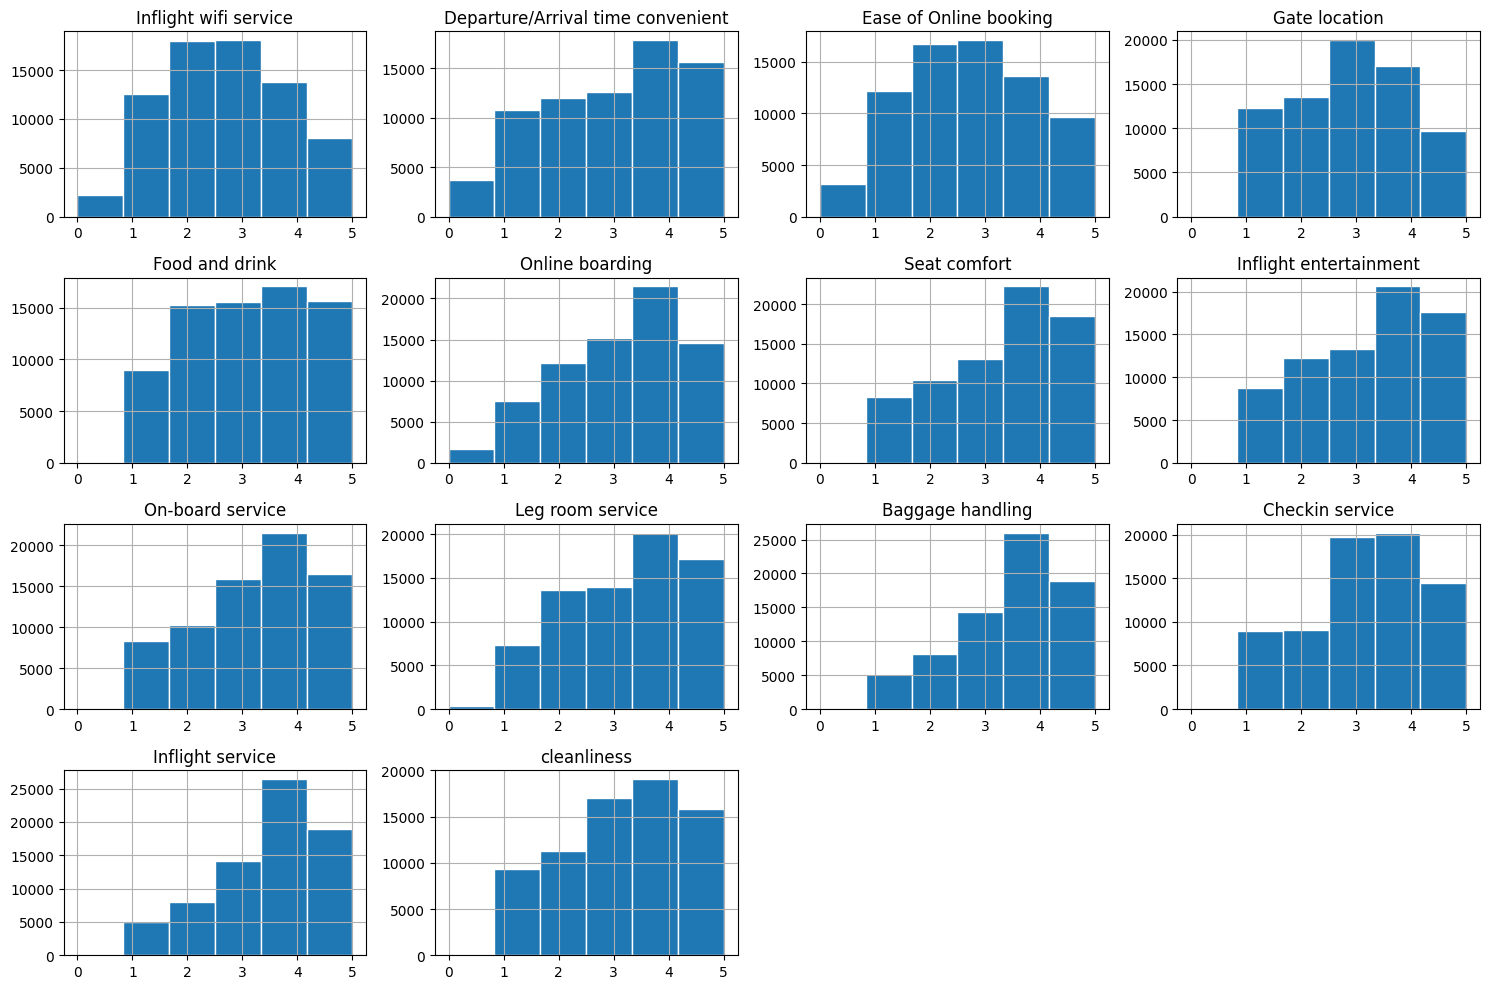

In [ ]:
# Гистограммы для признаков-"оценок"
X_train.select_dtypes(include=['float', 'int']).drop(['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis=1).hist(bins=6, range=(0, 5), figsize=(15, 10), edgecolor='white')
plt.tight_layout()
plt.show()

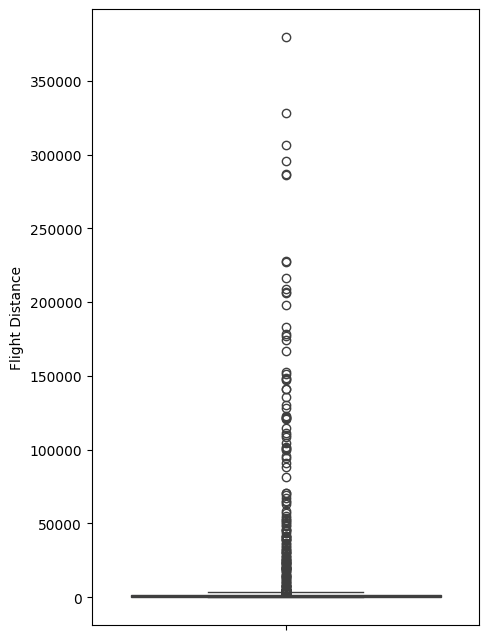

In [ ]:
# Flight Distance
plt.figure(figsize=(5, 8))
sns.boxplot(data=X_train['Flight Distance'])
plt.show()

Есть выбросы, которых достаточно много. Согласно [гуглу](https://www.google.com/search?q=%D0%BC%D0%B0%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F+%D0%B4%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C+%D0%BF%D0%BE%D0%BB%D1%91%D1%82%D0%B0+%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD%D1%81%D0%BA%D0%BE%D0%B9+%D0%B0%D0%B2%D0%B8%D0%B0%D1%86%D0%B8%D0%B8&oq=%D0%BC%D0%B0%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F+%D0%B4%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C+%D0%BF%D0%BE%D0%BB%D1%91%D1%82%D0%B0+%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD%D1%81%D0%BA%D0%BE%D0%B9+%D0%B0%D0%B2%D0%B8%D0%B0%D1%86%D0%B8%D0%B8&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCjE0ODgyajBqMTWoAgiwAgE&sourceid=chrome&ie=UTF-8), максимальная дальность полёта самолёта составляет 15400. Думаю, остальные значения можно считать выбросами, либо это налетал Starship.

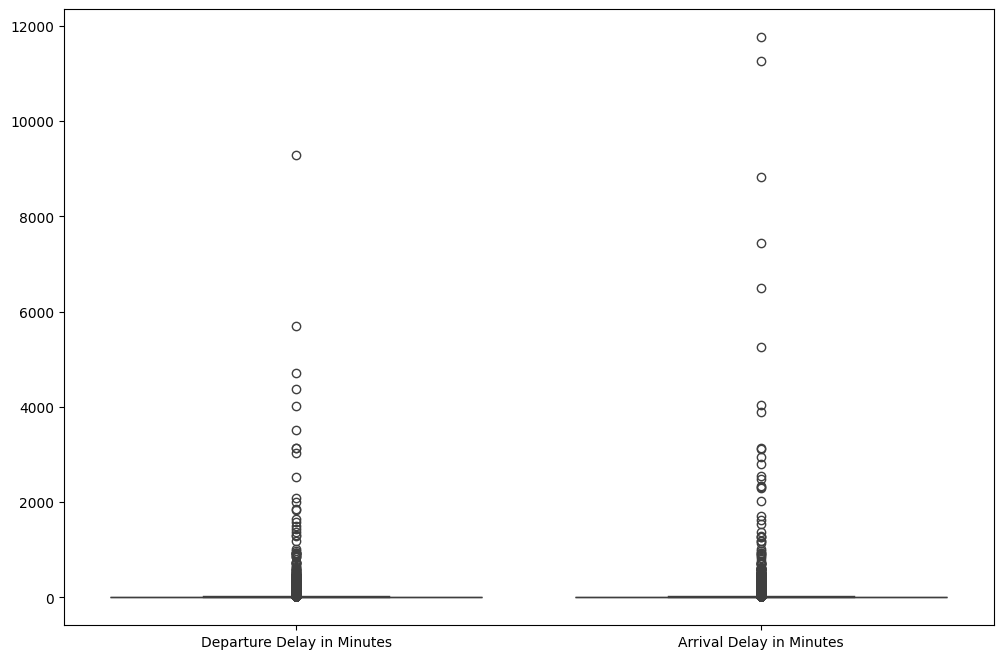

In [ ]:
# Departure Delay in Minutes & Arrival Delay in Minutes
plt.figure(figsize=(12, 8))
sns.boxplot(data=X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']])
plt.show()

Имеются очень сильные выбросы.

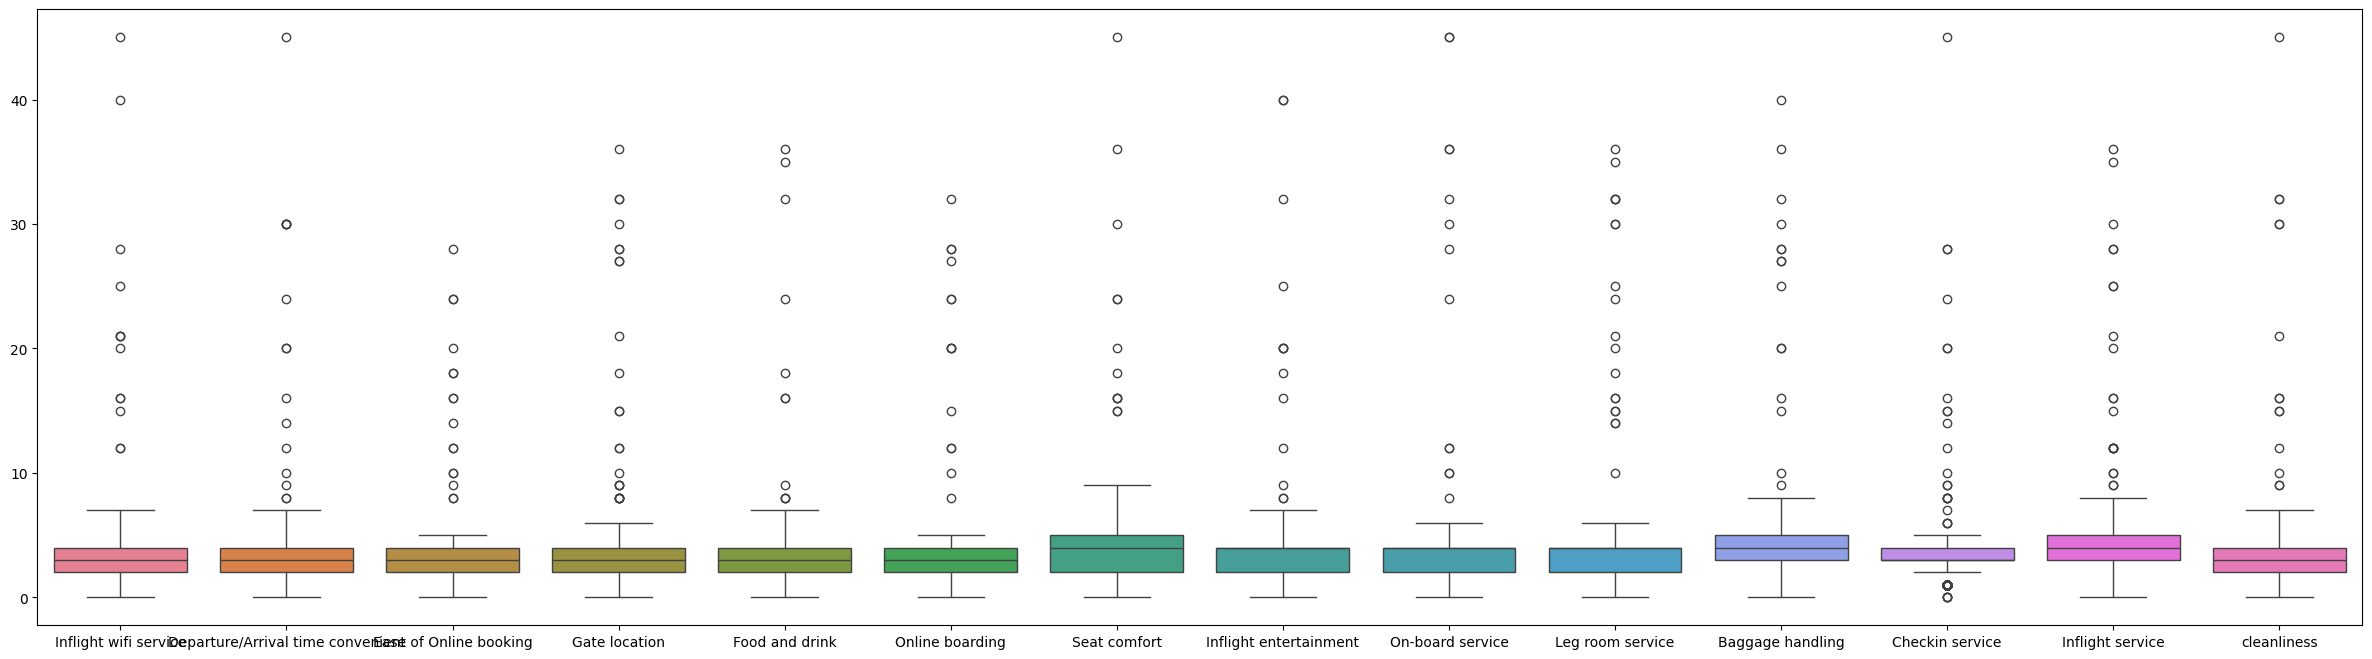

In [ ]:
# Boxplot для числовых признаков
plt.figure(figsize=(30, 8))
sns.boxplot(data=X_train.drop(['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis=1).select_dtypes(include=['float', 'int']))
plt.show()

На графике хорошо видно выбросы в оценках.

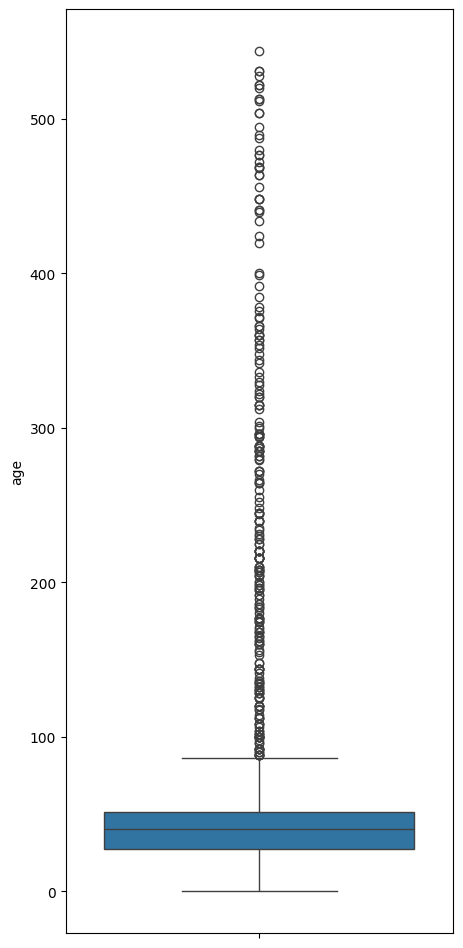

In [ ]:
# Boxplot для age
plt.figure(figsize=(5, 12))
sns.boxplot(data=X_train['age'])
plt.show()

Авиакомпания, бывает, перевозит очень старых пассажиров, некоторым уже более 500 лет. Вероятно это выбросы, но это не точно.

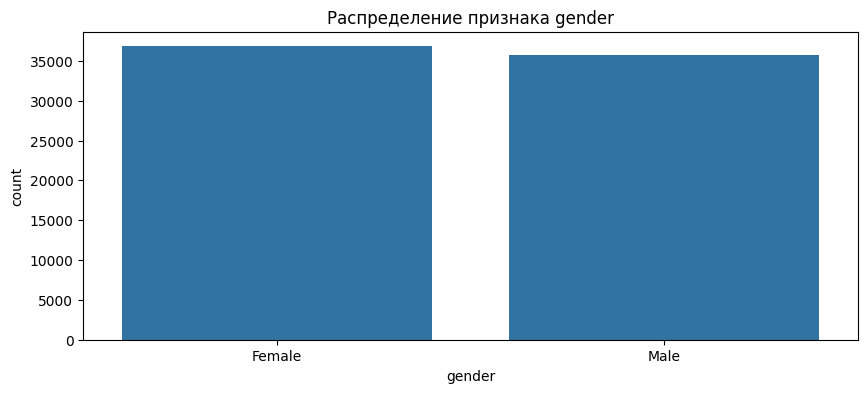

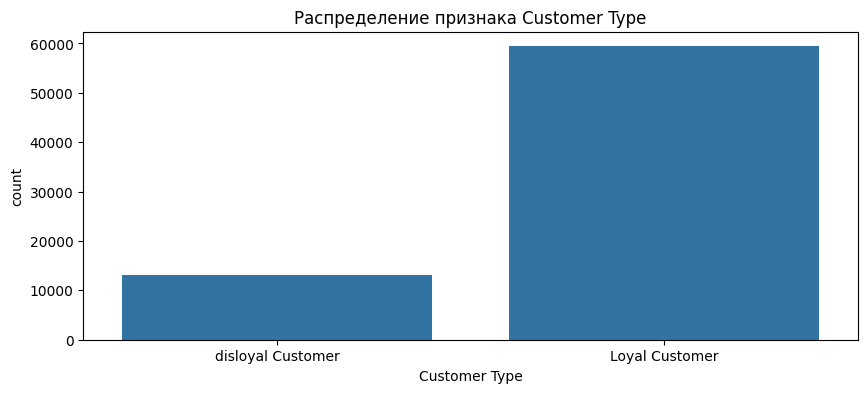

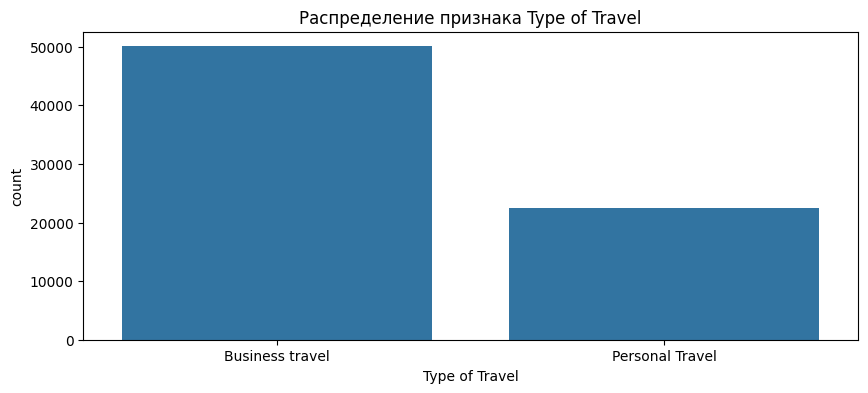

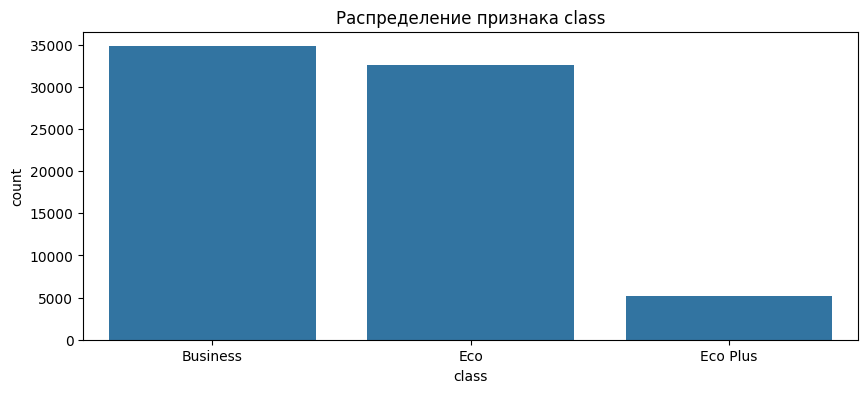

In [ ]:
for column in X_train.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=X_train, x=column)
    plt.title(f'Распределение признака {column}')
    plt.show()

Сильный дисбаланс виден в типе клиента, в основном у авиакомпании лояльные клиенты, также дисбаланс есть в типе поездки - чаще всего это корпоративные рейсы, а не персональное путешествие. Компания предоставляет 3 класса обслуживания и меньше всего летают Eco Plus.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [ ]:
# DELETE
X_train.shape

(72550, 22)

In [11]:
num_columns = X_train.select_dtypes(include=[np.number]).columns

def get_outlier_mask(df, num_columns, quantile=0.996):
    mask = pd.Series(True, index=df.index)
    for column in num_columns:
        threshold = df[column].quantile(quantile)
        mask &= (df[column] <= threshold)
    return mask

# сброс индексов
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# маска для выбросов
train_mask = get_outlier_mask(X_train, num_columns)
val_mask = get_outlier_mask(X_val, num_columns)

X_train = X_train[train_mask]
y_train = y_train[train_mask]

X_val = X_val[val_mask]
y_val = y_val[val_mask]

In [16]:
# DELETE
X_train.shape

(71395, 22)

In [ ]:
# DELETE

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(71395, 22)
(71395,)
(30588, 22)
(30588,)


In [ ]:
# DELETE
missing_values_3 = X_train.isnull().sum()
missing_values_3

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

In [ ]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [12]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [18]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [ ]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=df[col], hue=y, palette="Set2")
        plt.title(f"Распределение {col} по таргету")
        plt.xlabel(col)
        plt.ylabel("Частота")
        plt.legend(title="Таргет")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

In [ ]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # гистограмма распределения
        sns.histplot(data=df, x=col, hue=y, kde=True, ax=axes[0], palette='Set2')
        axes[0].set_title(f"Distribution of Continuous Feature: {col}", fontsize=14)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel("Density", fontsize=12)
        axes[0].legend(title="Target")

        # ящик с усами
        sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')
        axes[1].set_title(f"Boxplot of Continuous Feature: {col}", fontsize=14)
        axes[1].set_xlabel("Target", fontsize=12)
        axes[1].set_ylabel(col, fontsize=12)

        plt.tight_layout()
        plt.show()

In [ ]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=df[col], hue=y, palette="Set2")
        plt.title(f"Распределение {col} по таргету")
        plt.xlabel(col)
        plt.ylabel("Частота")
        plt.legend(title="Таргет")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

Отрисовка.

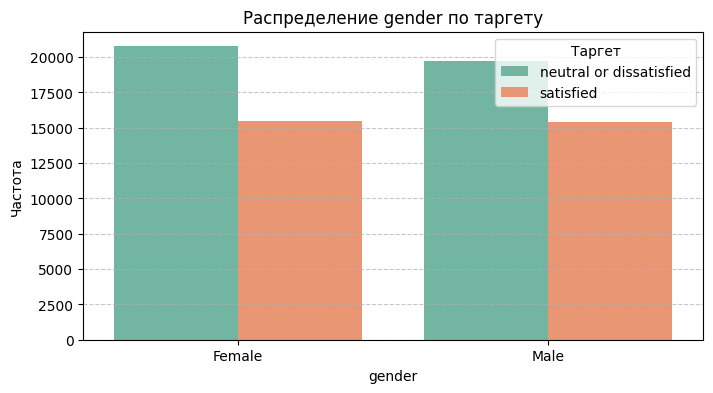

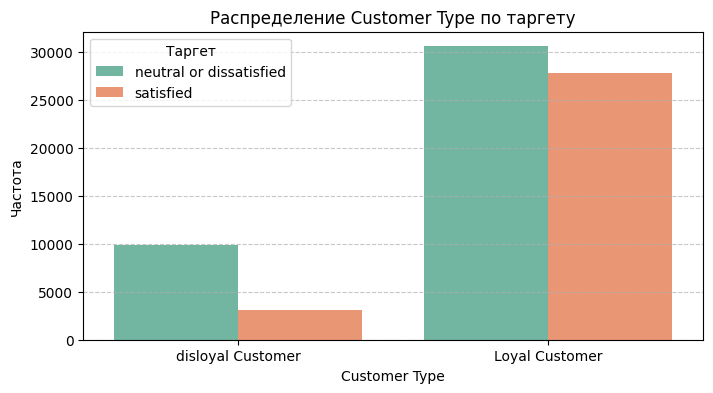

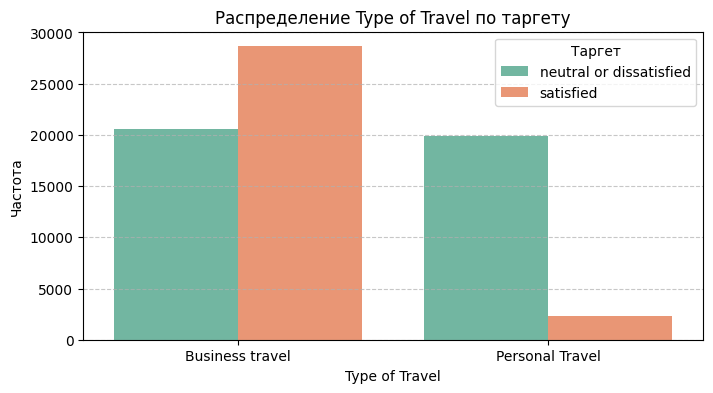

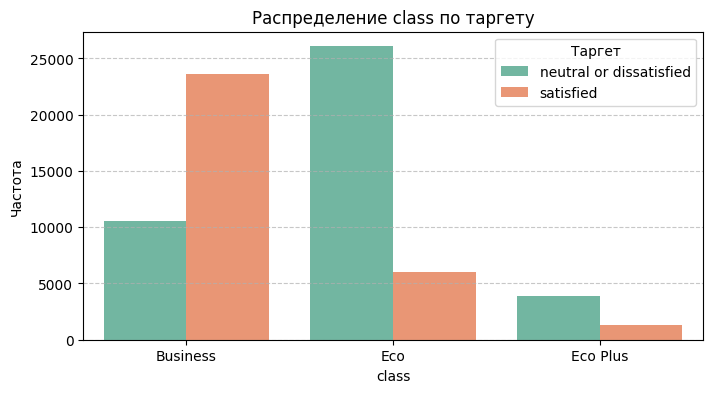

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


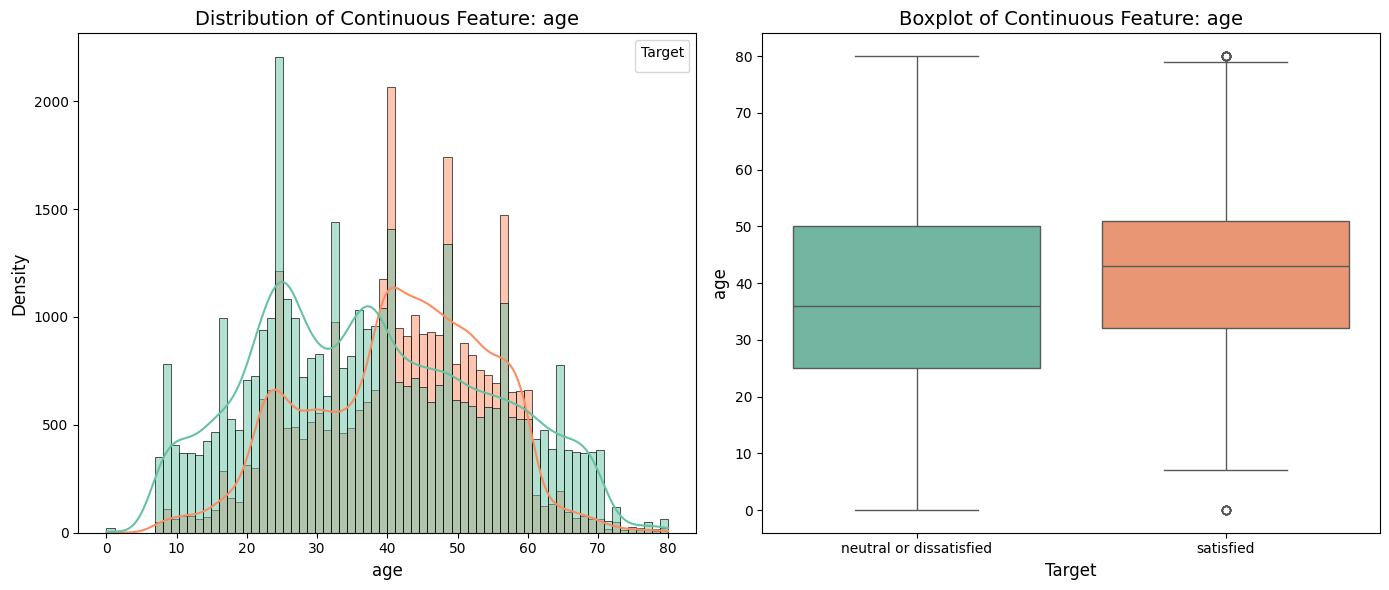

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


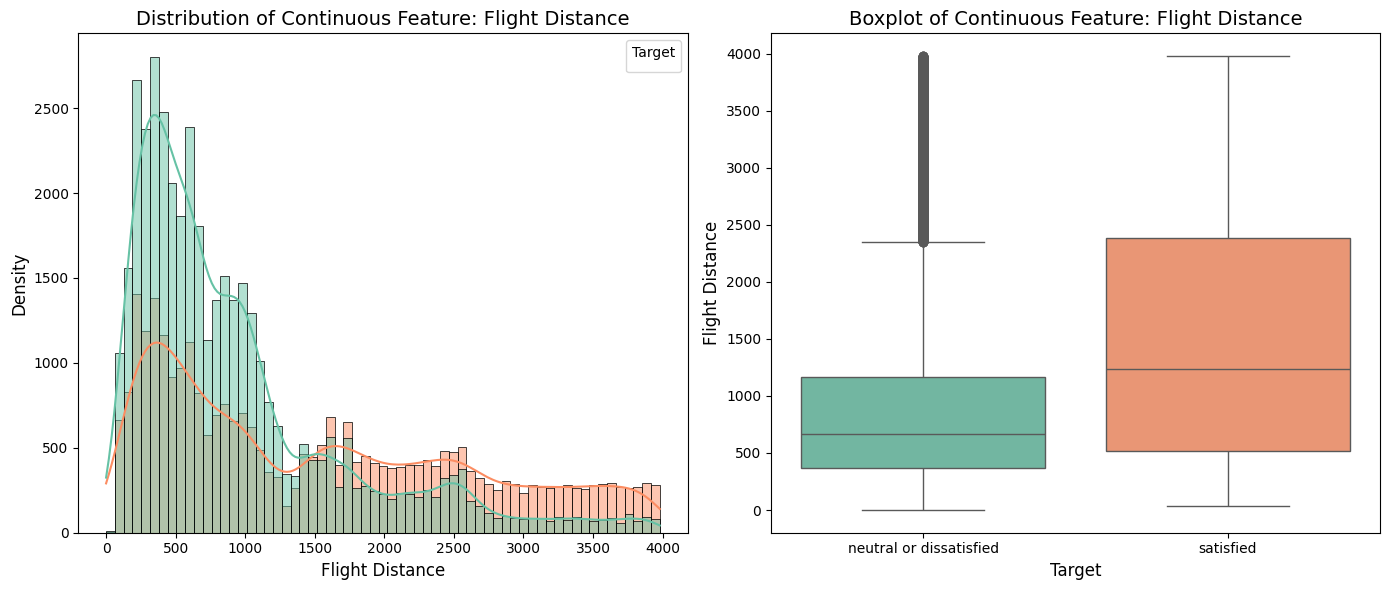

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


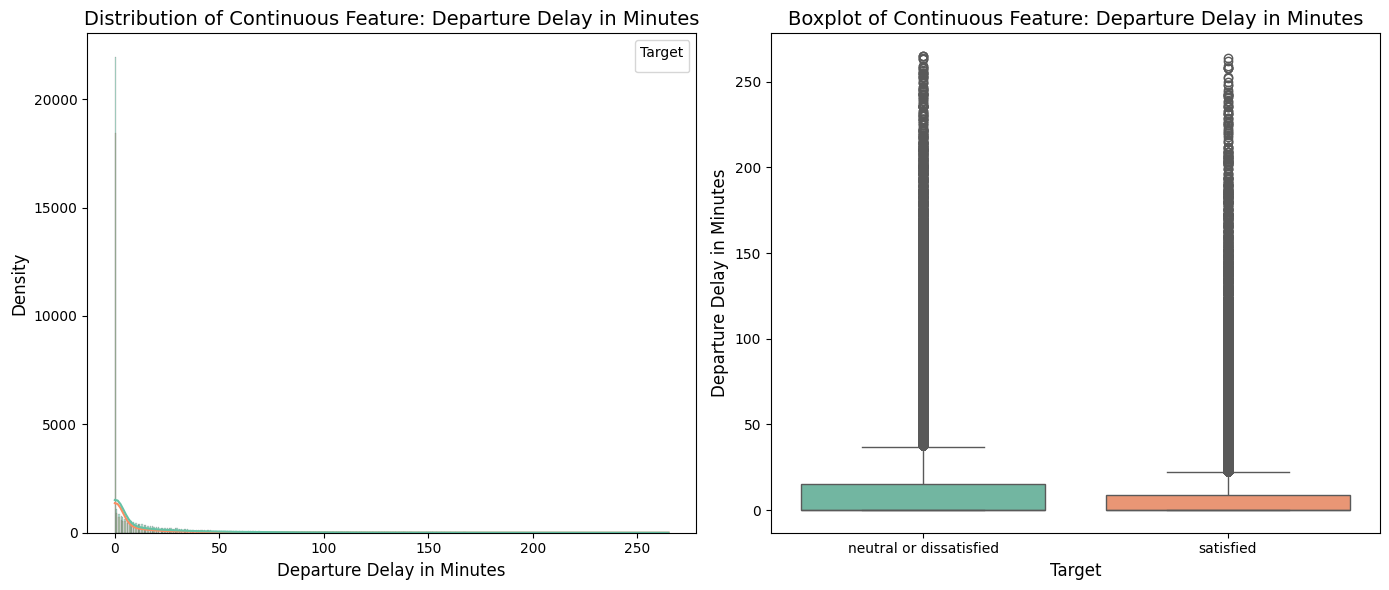

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


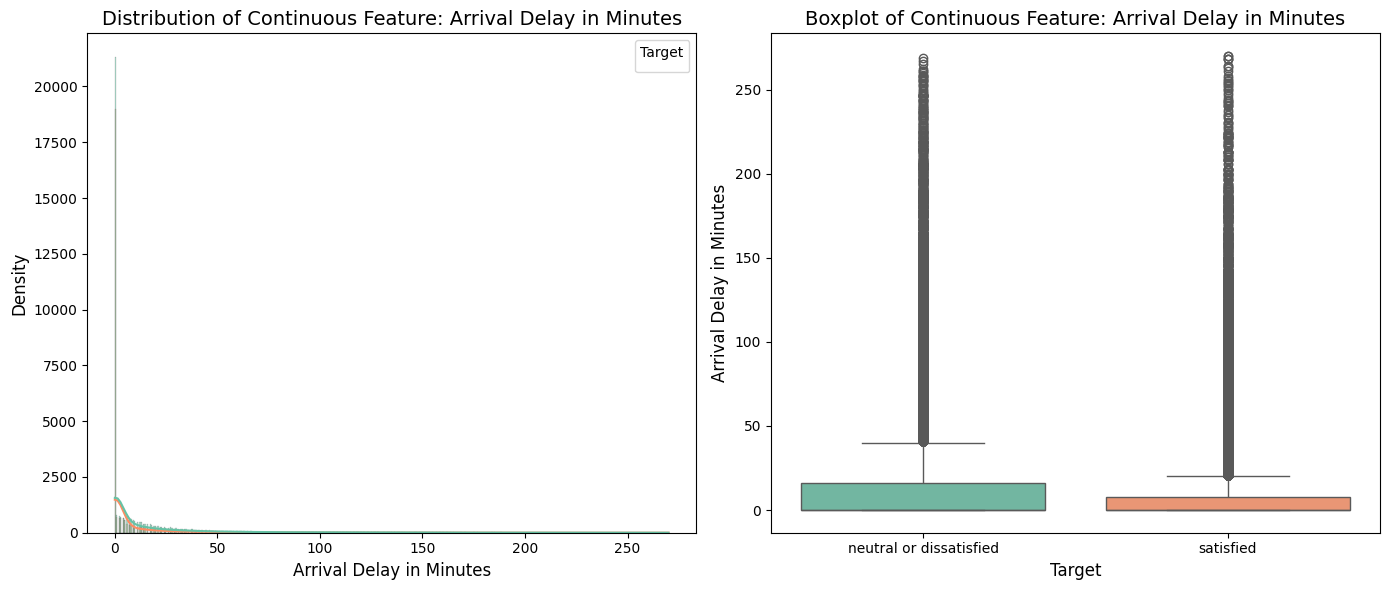

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

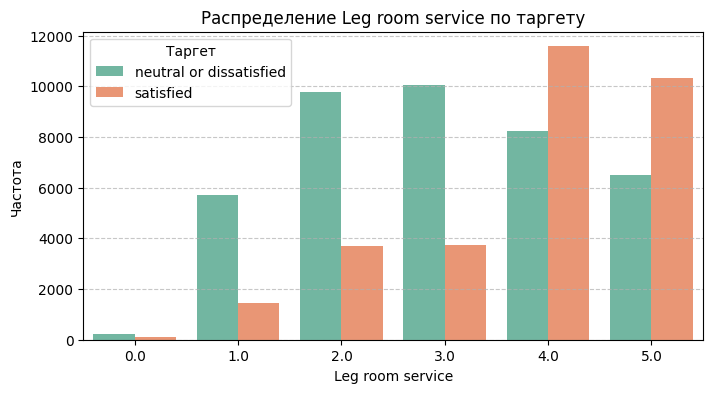

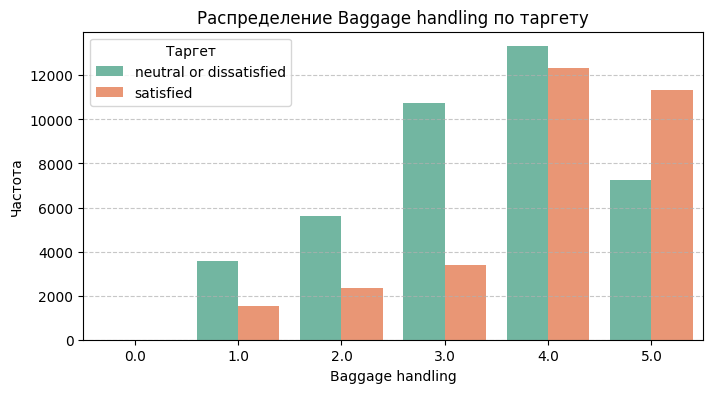

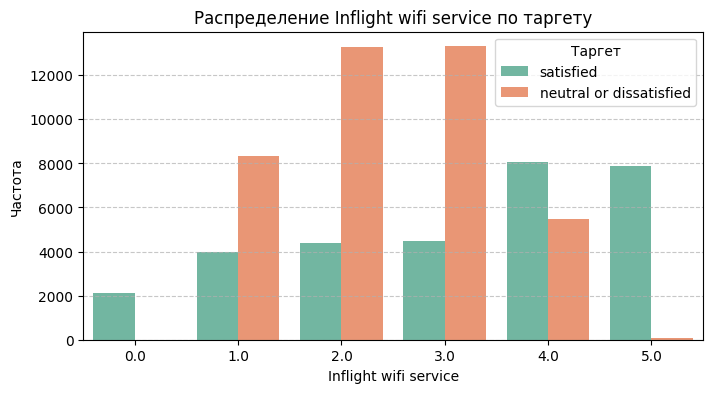

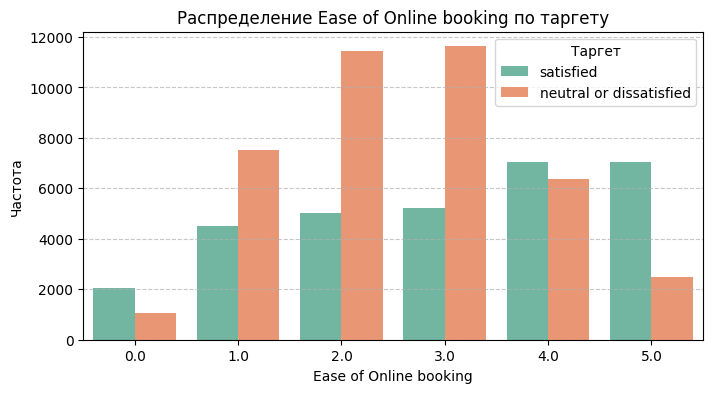

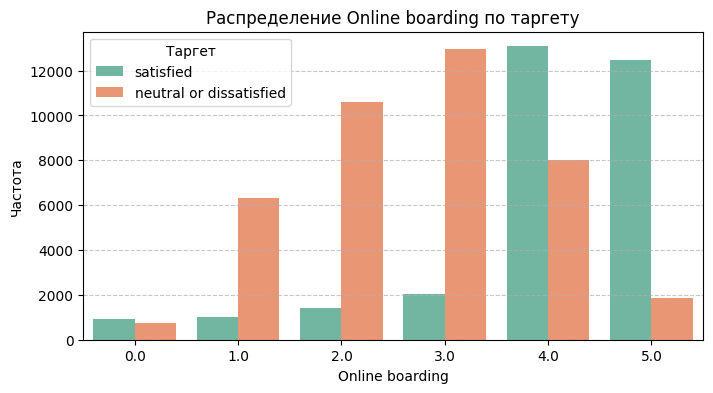

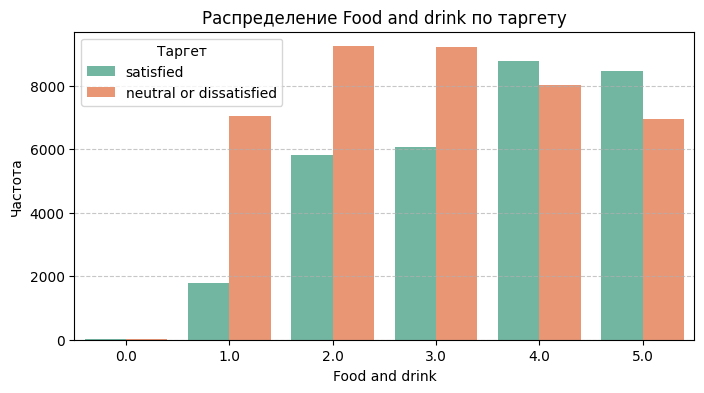

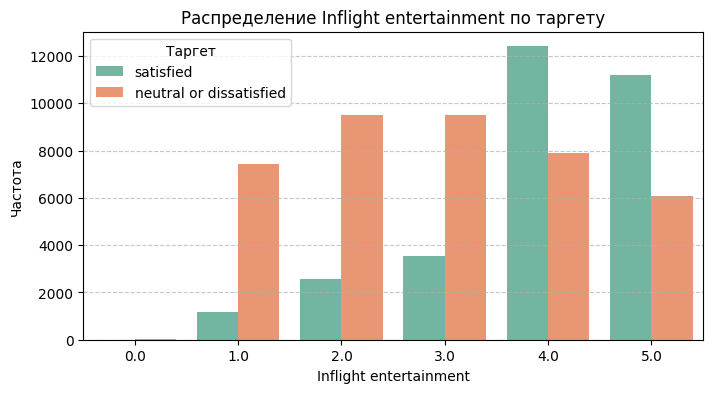

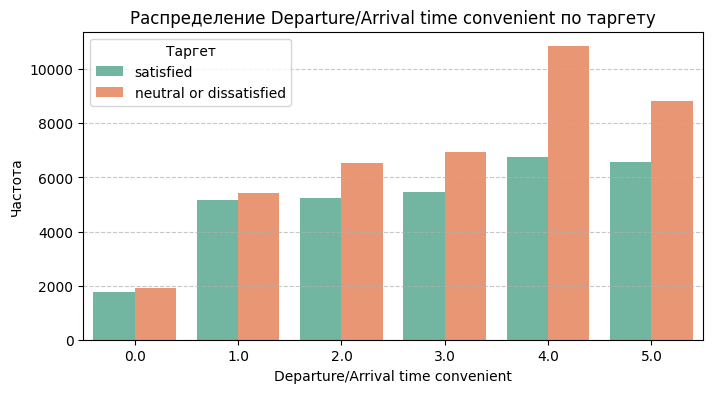

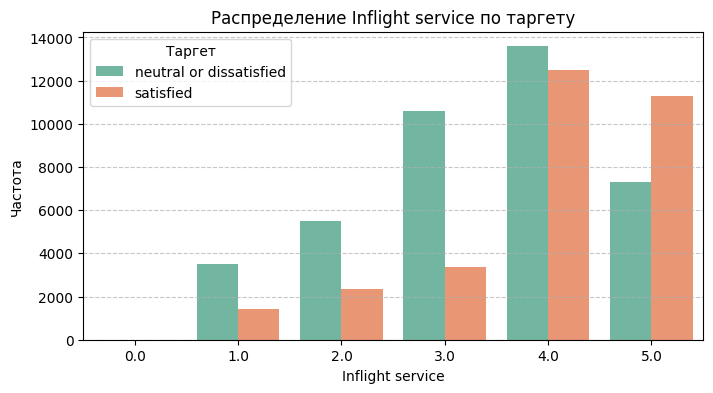

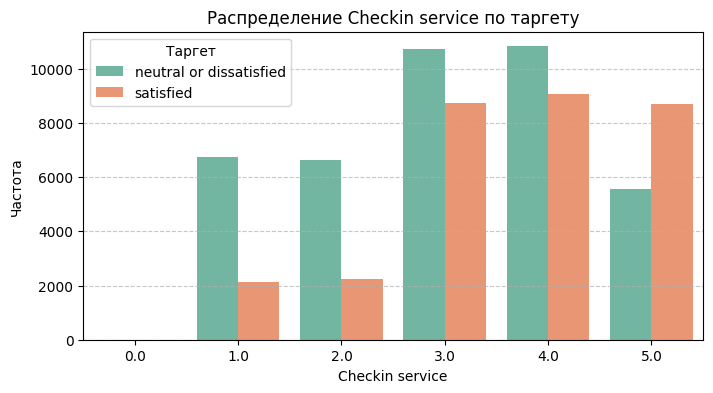

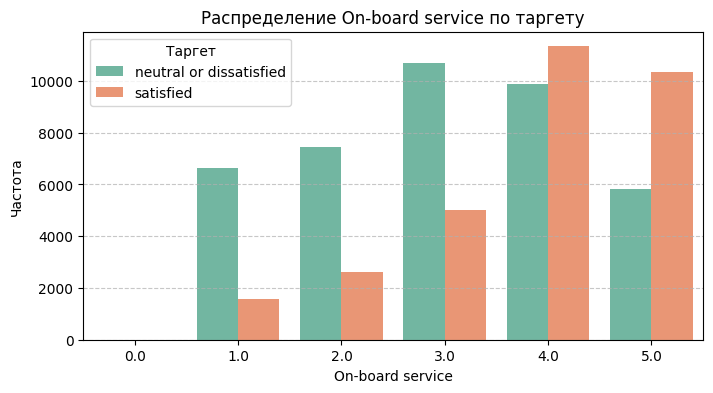

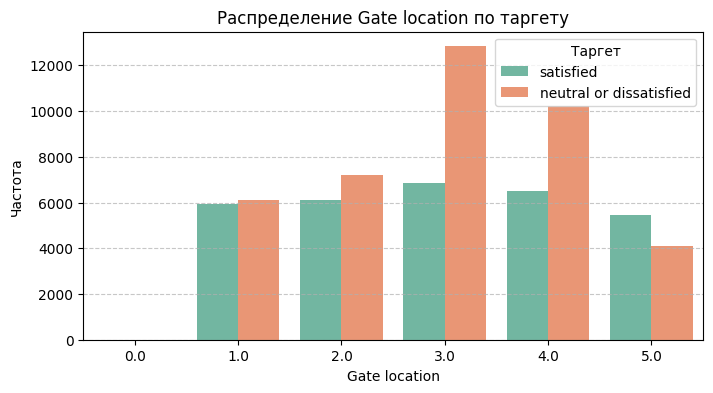

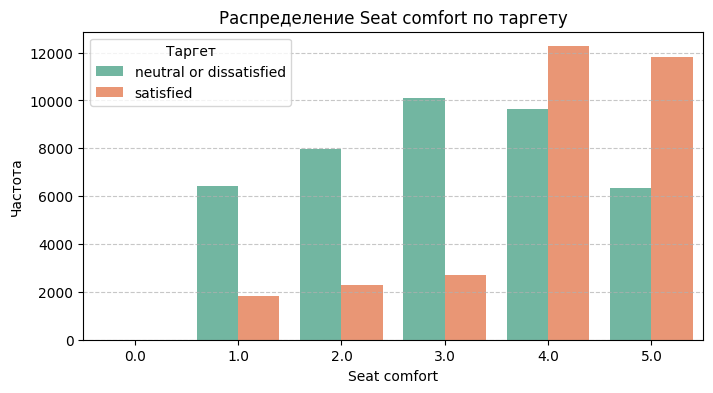

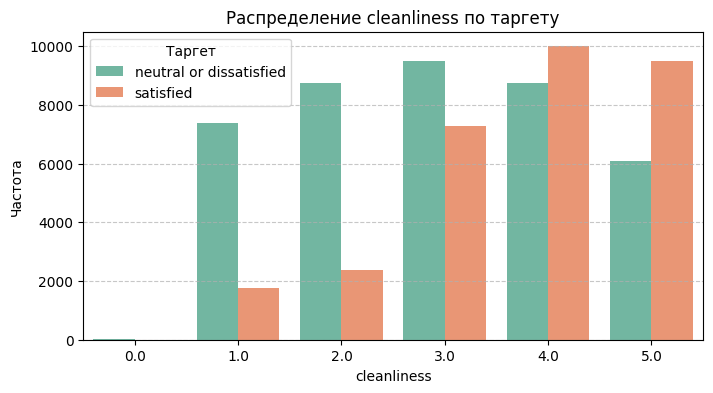

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

<ipython-input-87-a561a38c78a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


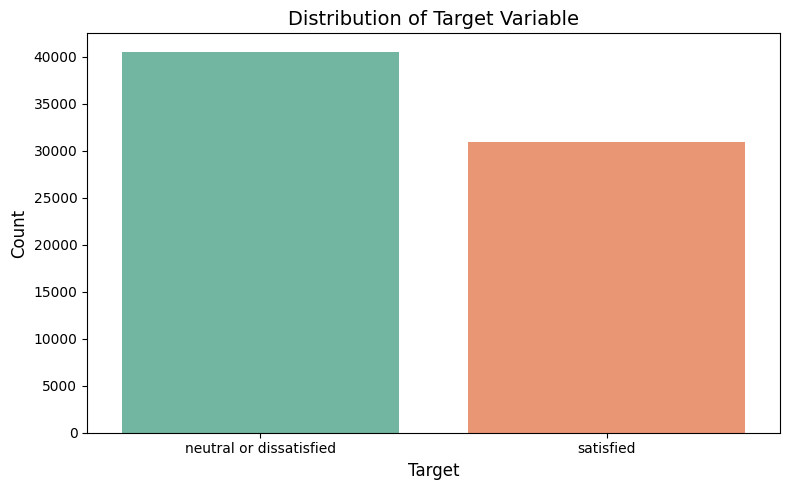

In [ ]:
# visualize y_train
def visualize_target(y):
    """Visualizes the distribution of the target variable"""
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y, palette='Set2')
    plt.title("Distribution of Target Variable", fontsize=14)
    plt.xlabel("Target", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_target(y_train)

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

**Исходя из графиков видно следующее:**
1. Лояльных клиентов намного больше
2. Удовлетворённых клиентов среди нелояльных клиентов намного меньше чем у лояльных.
3. В основном нетральные или неудовлетворённые клиенты остаются, когда тип путешествия - персональный и наоборот, если это бизнес поездка, то клиенты в большей части остаются удовлетворены.
4. Если посмотреть на класс обслуживания, то видно, что большая часть неудовлетворённых клиентов летело эконом классом Eco. В бизнес классе более 70% остались удовлетворены
5. Если смотреть по возрасту, то более неудовлетворёнными клиентами были более молодые клиенты.
6. При более дальних полётах, клиенты чаще оказывались удовлетворены, а при коротких - наоборот.
7. Если смотреть по таргету, то больше у нас нейтральных или неудовлетворённых клиентов, но разница между удовлетворёнными не сильная.



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [ ]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [ ]:
# DELETE

def apply_log_transform(df, columns):
    """
    Применяет логарифмическое преобразование к указанным столбцам.
    Добавляет небольшую константу (1), чтобы избежать ошибок с log(0).
    """
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = np.log1p(df_copy[col]) # log1p(x) = log(x + 1)
    return df_copy

log_columns = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
apply_log_transform(X_train, log_columns)

In [ ]:
def apply_log_transform(df, columns):
    """
    Применяет логарифмическое преобразование к указанным столбцам.
    Добавляет небольшую константу (1), чтобы избежать ошибок с log(0).
    """
    for col in columns:
        df[col] = np.log1p(df[col])  # log1p(x) = log(x + 1)

log_columns = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
apply_log_transform(X_train, log_columns)

Построение.

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


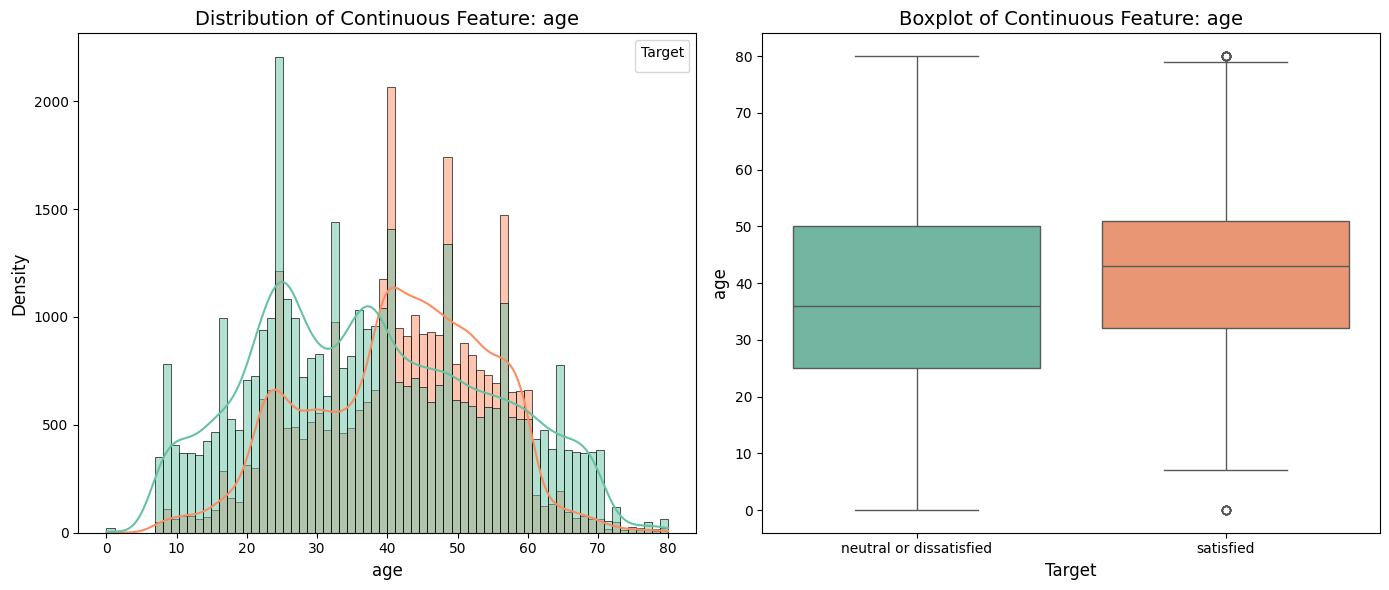

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


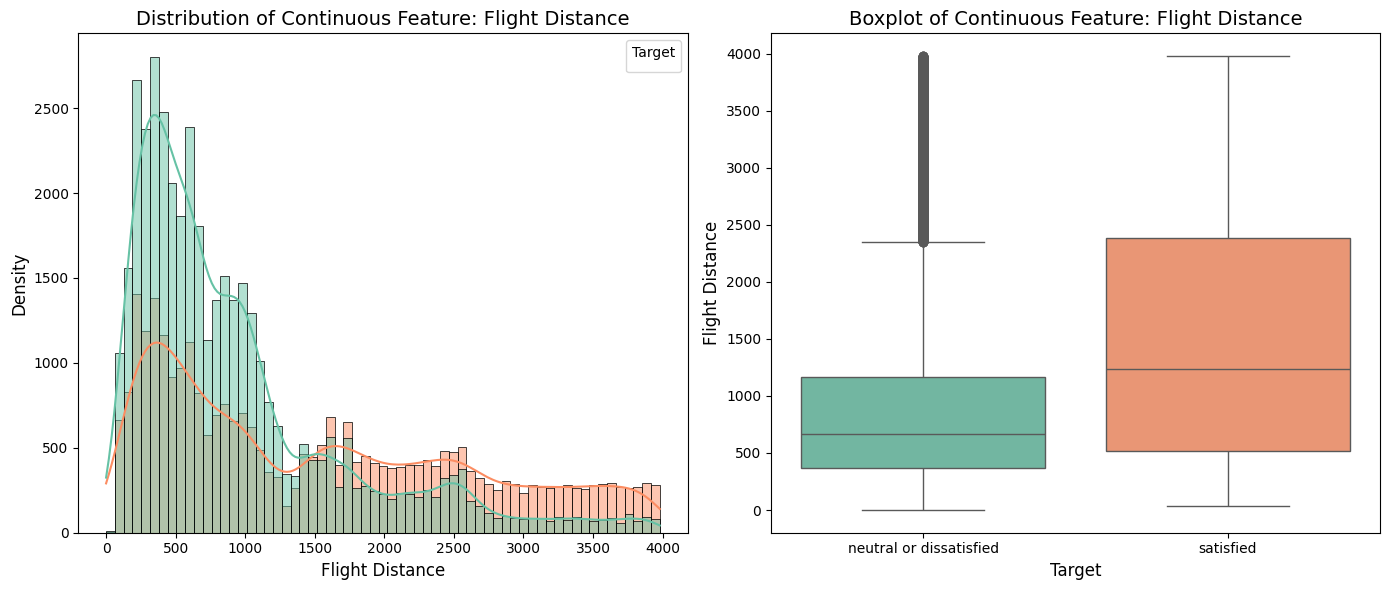

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


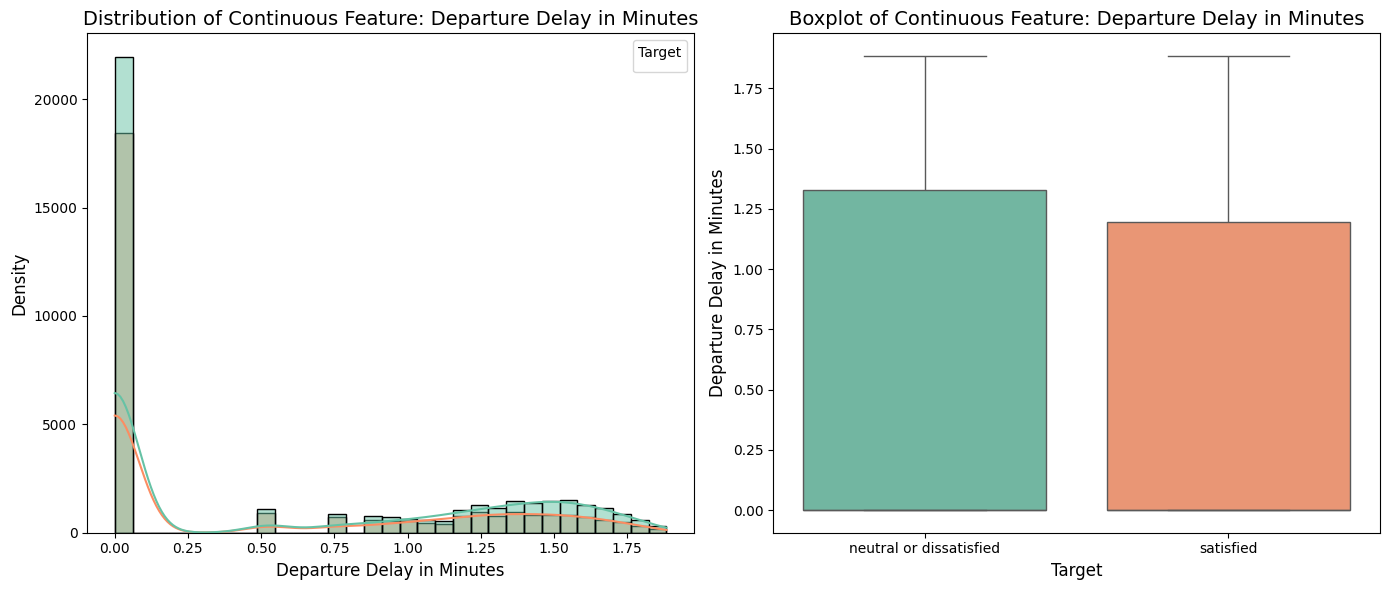

<ipython-input-82-9183663a6242>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Target")
<ipython-input-82-9183663a6242>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=y, y=col, ax=axes[1], palette='Set2')


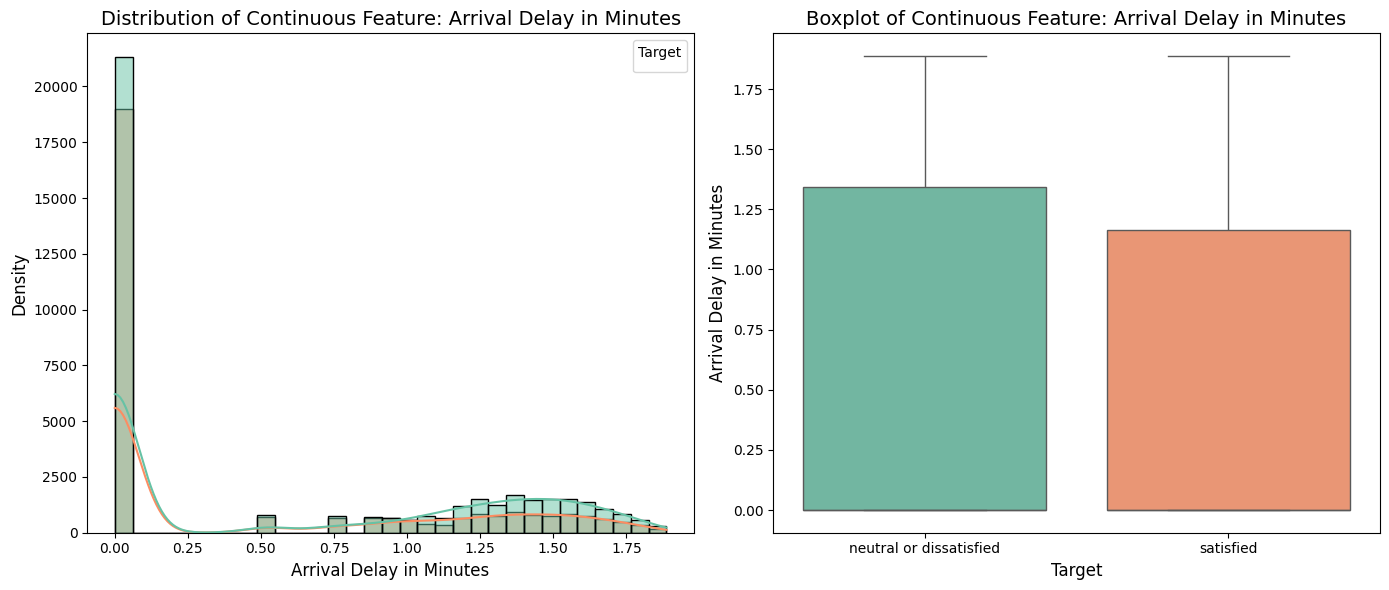

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

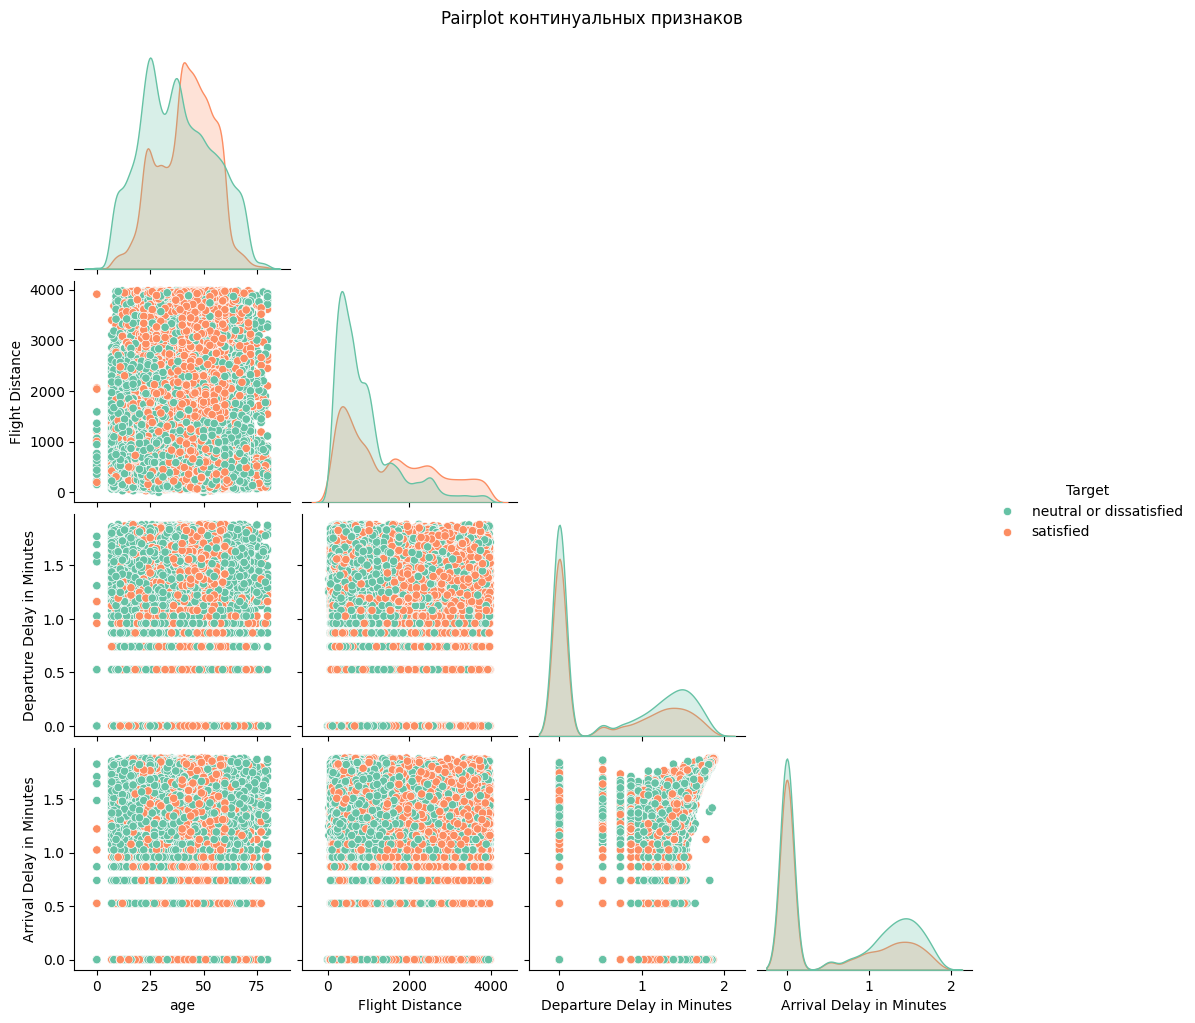

In [ ]:
df_train_continuous = X_train[continuous_cols].copy()
df_train_continuous['Target'] = y_train

sns.pairplot(
    data=df_train_continuous,
    hue='Target',
    palette='Set2',
    diag_kind='kde', # на диагонали отображаем KDE (ядерную оценку плотности)
    corner=True
)

plt.suptitle("Pairplot континуальных признаков", y=1.02)
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [13]:
y_train = (y_train == 'satisfied').astype(int)
y_val = (y_val == 'satisfied').astype(int)
y_train

0        0
1        1
2        0
3        0
4        1
        ..
72545    0
72546    0
72547    0
72548    1
72549    0
Name: satisfaction, Length: 71395, dtype: int64

In [ ]:
# DELETE
missing_values_4 = X_train.isnull().sum()
missing_values_4

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

In [ ]:
# DELETE

X_train['cleanliness'].unique()

array([4., 1., 5., 3., 2., 0.])

In [ ]:
# DELETE

X_train.shape

(71395, 22)

In [ ]:
# DELETE

print(X_train.duplicated().sum())
print(X_val.duplicated().sum())

0
0


In [ ]:
# DELETE

print(X_train.index.is_unique)
print(X_val.index.is_unique)

True
True


In [14]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

X_train_cat_encoded = ohe.fit_transform(X_train[categorical_cols])
X_val_cat_encoded = ohe.transform(X_val[categorical_cols])

X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)
X_val_cat_encoded_df = pd.DataFrame(X_val_cat_encoded, columns=ohe.get_feature_names_out(), index=X_val.index)

X_train = pd.concat([X_train.drop(columns=categorical_cols), X_train_cat_encoded_df], axis=1)
X_val = pd.concat([X_val.drop(columns=categorical_cols), X_val_cat_encoded_df], axis=1)

X_train

age  Flight Distance  Departure Delay in Minutes  \
0      29.0            785.0                         0.0   
1      45.0           3269.0                         0.0   
2       8.0           1431.0                         0.0   
3      48.0            602.0                         0.0   
4      25.0            651.0                         0.0   
...     ...              ...                         ...   
71390  25.0            337.0                         0.0   
71391  77.0           1448.0                         0.0   
71392  31.0            304.0                        21.0   
71393  45.0            661.0                         0.0   
71394  55.0           1359.0                         0.0   

       Arrival Delay in Minutes  Inflight wifi service  \
0                           0.0                    2.0   
1                           0.0                    0.0   
2                           0.0                    3.0   
3                           0.0                    4.0   
4                           0.0                    5.0   
...                         ...                    ...   
71390                       0.0                    1.0   
71391                       0.0                    2.0   
71392                      12.0                    4.0   
71393                       0.0                    4.0   
71394                       0.0                    3.0   

       Departure/Arrival time convenient  Ease of Online booking  \
0                                    2.0                     2.0   
1                                    0.0                     0.0   
2                                    1.0                     3.0   
3                                    5.0                     4.0   
4                                    0.0                     5.0   
...                                  ...                     ...   
71390                                4.0                     1.0   
71391                                5.0                     5.0   
71392                                4.0                     4.0   
71393                                1.0                     4.0   
71394                                3.0                     3.0   

       Gate location  Food and drink  Online boarding  ...  Leg room service  \
0                4.0             4.0              2.0  ...               3.0   
1                3.0             2.0              2.0  ...               3.0   
2                2.0             5.0              3.0  ...               5.0   
3                3.0             2.0              5.0  ...               4.0   
4                2.0             2.0              5.0  ...               1.0   
...              ...             ...              ...  ...               ...   
71390            4.0             4.0              1.0  ...               4.0   
71391            5.0             2.0              2.0  ...               2.0   
71392            1.0             1.0              4.0  ...               3.0   
71393            4.0             2.0              4.0  ...               3.0   
71394            3.0             3.0              3.0  ...               1.0   

       Baggage handling  Checkin service  Inflight service  cleanliness  \
0                   5.0              4.0               5.0          4.0   
1                   3.0              5.0               3.0          1.0   
2                   2.0              2.0               1.0          5.0   
3                   2.0              3.0               4.0          3.0   
4                   2.0              3.0               1.0          2.0   
...                 ...              ...               ...          ...   
71390               4.0              4.0               4.0          4.0   
71391               4.0              3.0               3.0          2.0   
71392               5.0              4.0               5.0          1.0   
71393               4.0              3.0               4.0    

In [ ]:
# DELETE
missing_values_5 = X_train.isnull().sum()
missing_values_5

age                                  0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
gender_Male                          0
Customer Type_disloyal Customer      0
Type of Travel_Personal Travel       0
class_Eco                            0
class_Eco Plus                       0
dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71395 entries, 0 to 71394
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                71395 non-null  float64
 1   Flight Distance                    71395 non-null  float64
 2   Departure Delay in Minutes         71395 non-null  float64
 3   Arrival Delay in Minutes           71395 non-null  float64
 4   Inflight wifi service              71395 non-null  float64
 5   Departure/Arrival time convenient  71395 non-null  float64
 6   Ease of Online booking             71395 non-null  float64
 7   Gate location                      71395 non-null  float64
 8   Food and drink                     71395 non-null  float64
 9   Online boarding                    71395 non-null  float64
 10  Seat comfort                       71395 non-null  float64
 11  Inflight entertainment             71395 non-null  flo

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
# DELETE

print(y_train.shape)
print(X_train.shape)

(71395,)
(71395, 23)


In [15]:
# Ваш код ниже
dt = DecisionTreeClassifier(random_state=123)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)

print(f"Accuracy: {accuracy_score(y_pred, y_val):.2f}")

Accuracy: 0.94


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [16]:
error_dt, bias_dt, var_dt = bias_variance_decomp(dt,
                                                 X_train.values,
                                                 y_train.values,
                                                 X_val.values,
                                                 y_val.values,
                                                 loss = '0-1_loss',
                                                 random_seed = 123,
                                                 num_rounds=20,
                                                 )
error_dt, bias_dt, var_dt

(0.06147181901399242, 0.0417483980646005, 0.04415457041977246)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
print(f"Глубина дерева: {dt.get_depth()}, Количество листьев: {dt.get_n_leaves()}")

Глубина дерева: 26, Количество листьев: 2097


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

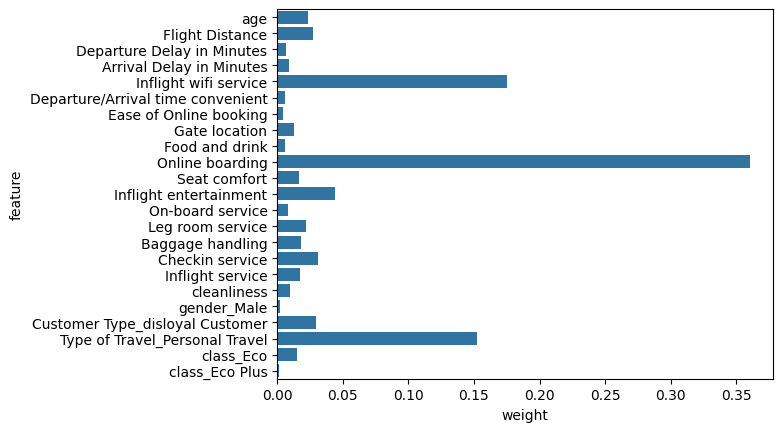

In [ ]:
dt_importances = pd.DataFrame({"feature": X_val.columns,
                        "weight": dt.feature_importances_})
sns.barplot(data=dt_importances, y="feature", x="weight")
plt.show()

<ipython-input-29-fdb554b8bbf7>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


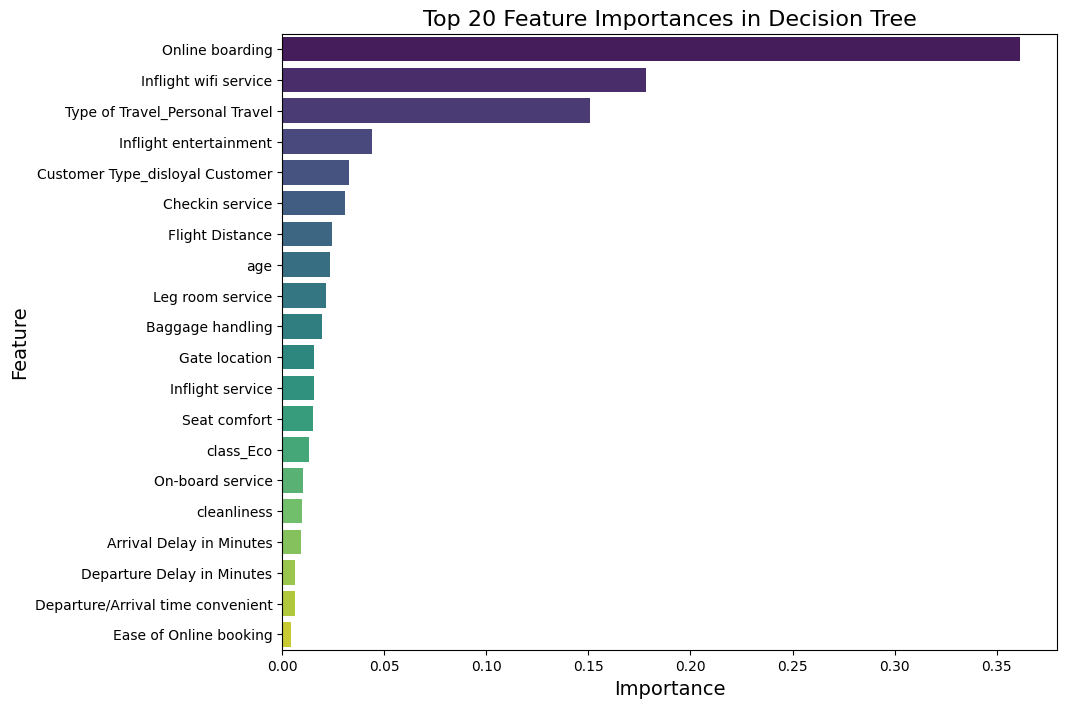

In [ ]:
# получаем "встроенную" важность признаков
feature_importances = dt.feature_importances_

# DataFrame для удобства визуализации
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# график топ 20 самых важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances in Decision Tree', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

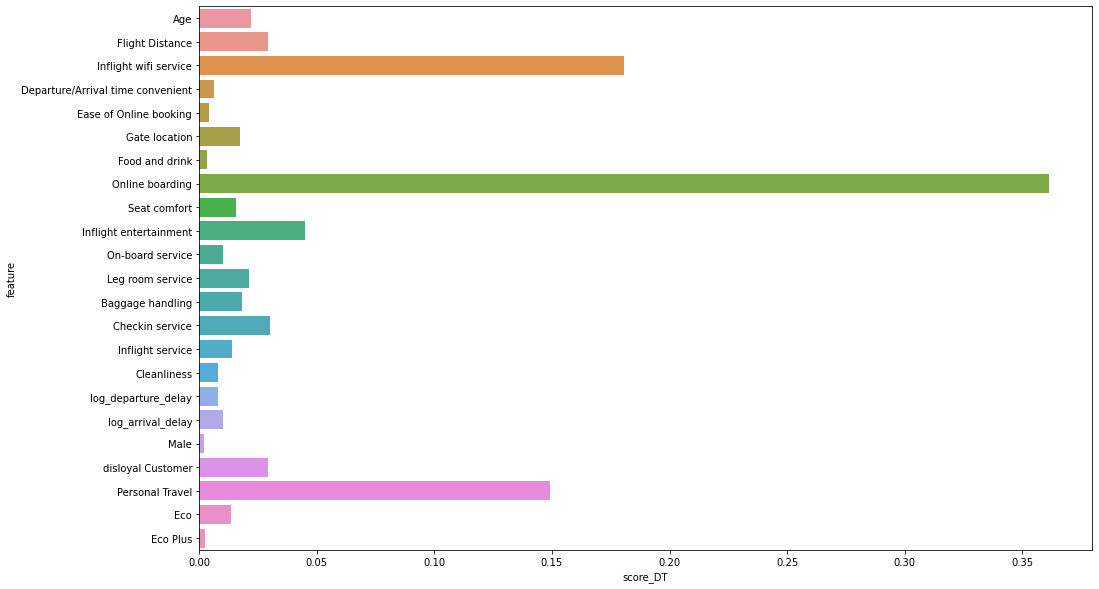

In [ ]:
# Ваш код здесь

Наиболее информативны следующие признаки:
- Online boarding
- Inflight wifi service
- Type of Travel

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
# Ваш код здесь

feature_importances = dt.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_2_features = importance_df.head(2)['Feature'].tolist()
print("Два наиболее важных признака:", top_2_features)

X_train_top2 = X_train[top_2_features]
X_val_top2 = X_val[top_2_features]

dt_2 = DecisionTreeClassifier(random_state=13, max_depth=5)

dt_2.fit(X_train_top2, y_train)
y_pred = dt_2.predict(X_val_top2)

print(f"Accuracy: {accuracy_score(y_pred, y_val):.2f}")

Два наиболее важных признака: ['Online boarding', 'Inflight wifi service']
Accuracy: 0.82


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [ ]:
dot_data = export_graphviz(
    dt_2,
    out_file=None,
    feature_names=X_train_top2.columns,
    filled=True)

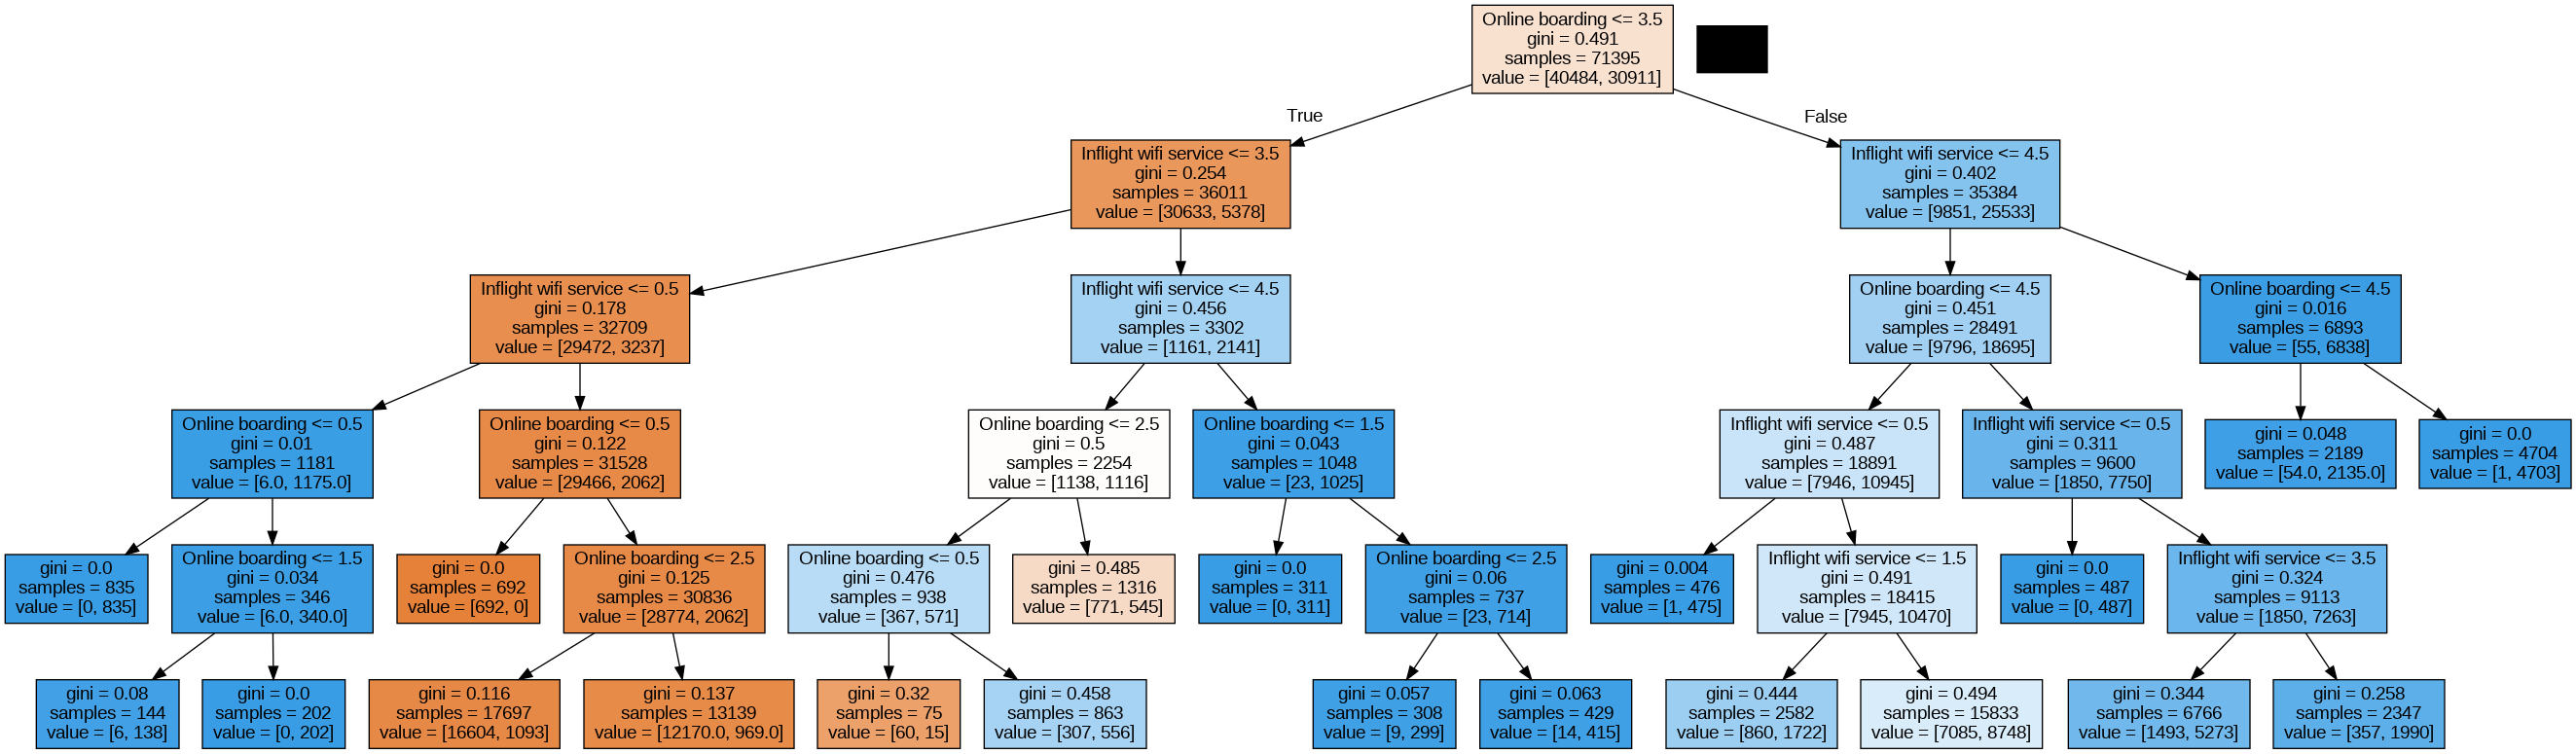

In [ ]:
import pydotplus
from IPython.display import Image

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


`Пример кода взят из статьи Anantha Kattani - https://anantha-kattani.medium.com/visualizing-a-decision-tree-using-graphviz-and-pydotplus-24a046faac0b`

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

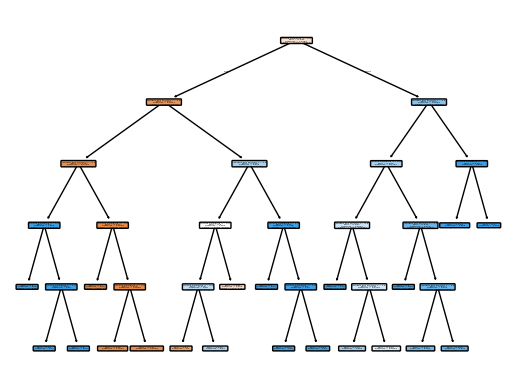

In [ ]:
plot_tree(dt_2, feature_names=X_train_top2.columns, filled=True, rounded=True)
plt.show()

Дерево получилось не симметричным. ...

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [ ]:
X_train_top2.columns

Index(['Online boarding', 'Inflight wifi service'], dtype='object')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


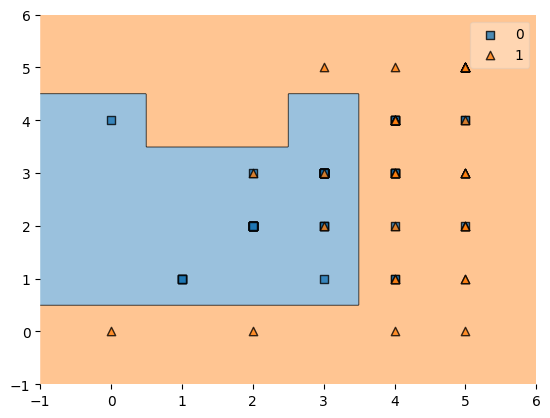

In [ ]:
plot_decision_regions(X_train_top2.values[:100], y_train.values[:100], dt_2)
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [21]:
X_train_top2 = X_train_top2.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

NameError: name 'X_train_top2' is not defined

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

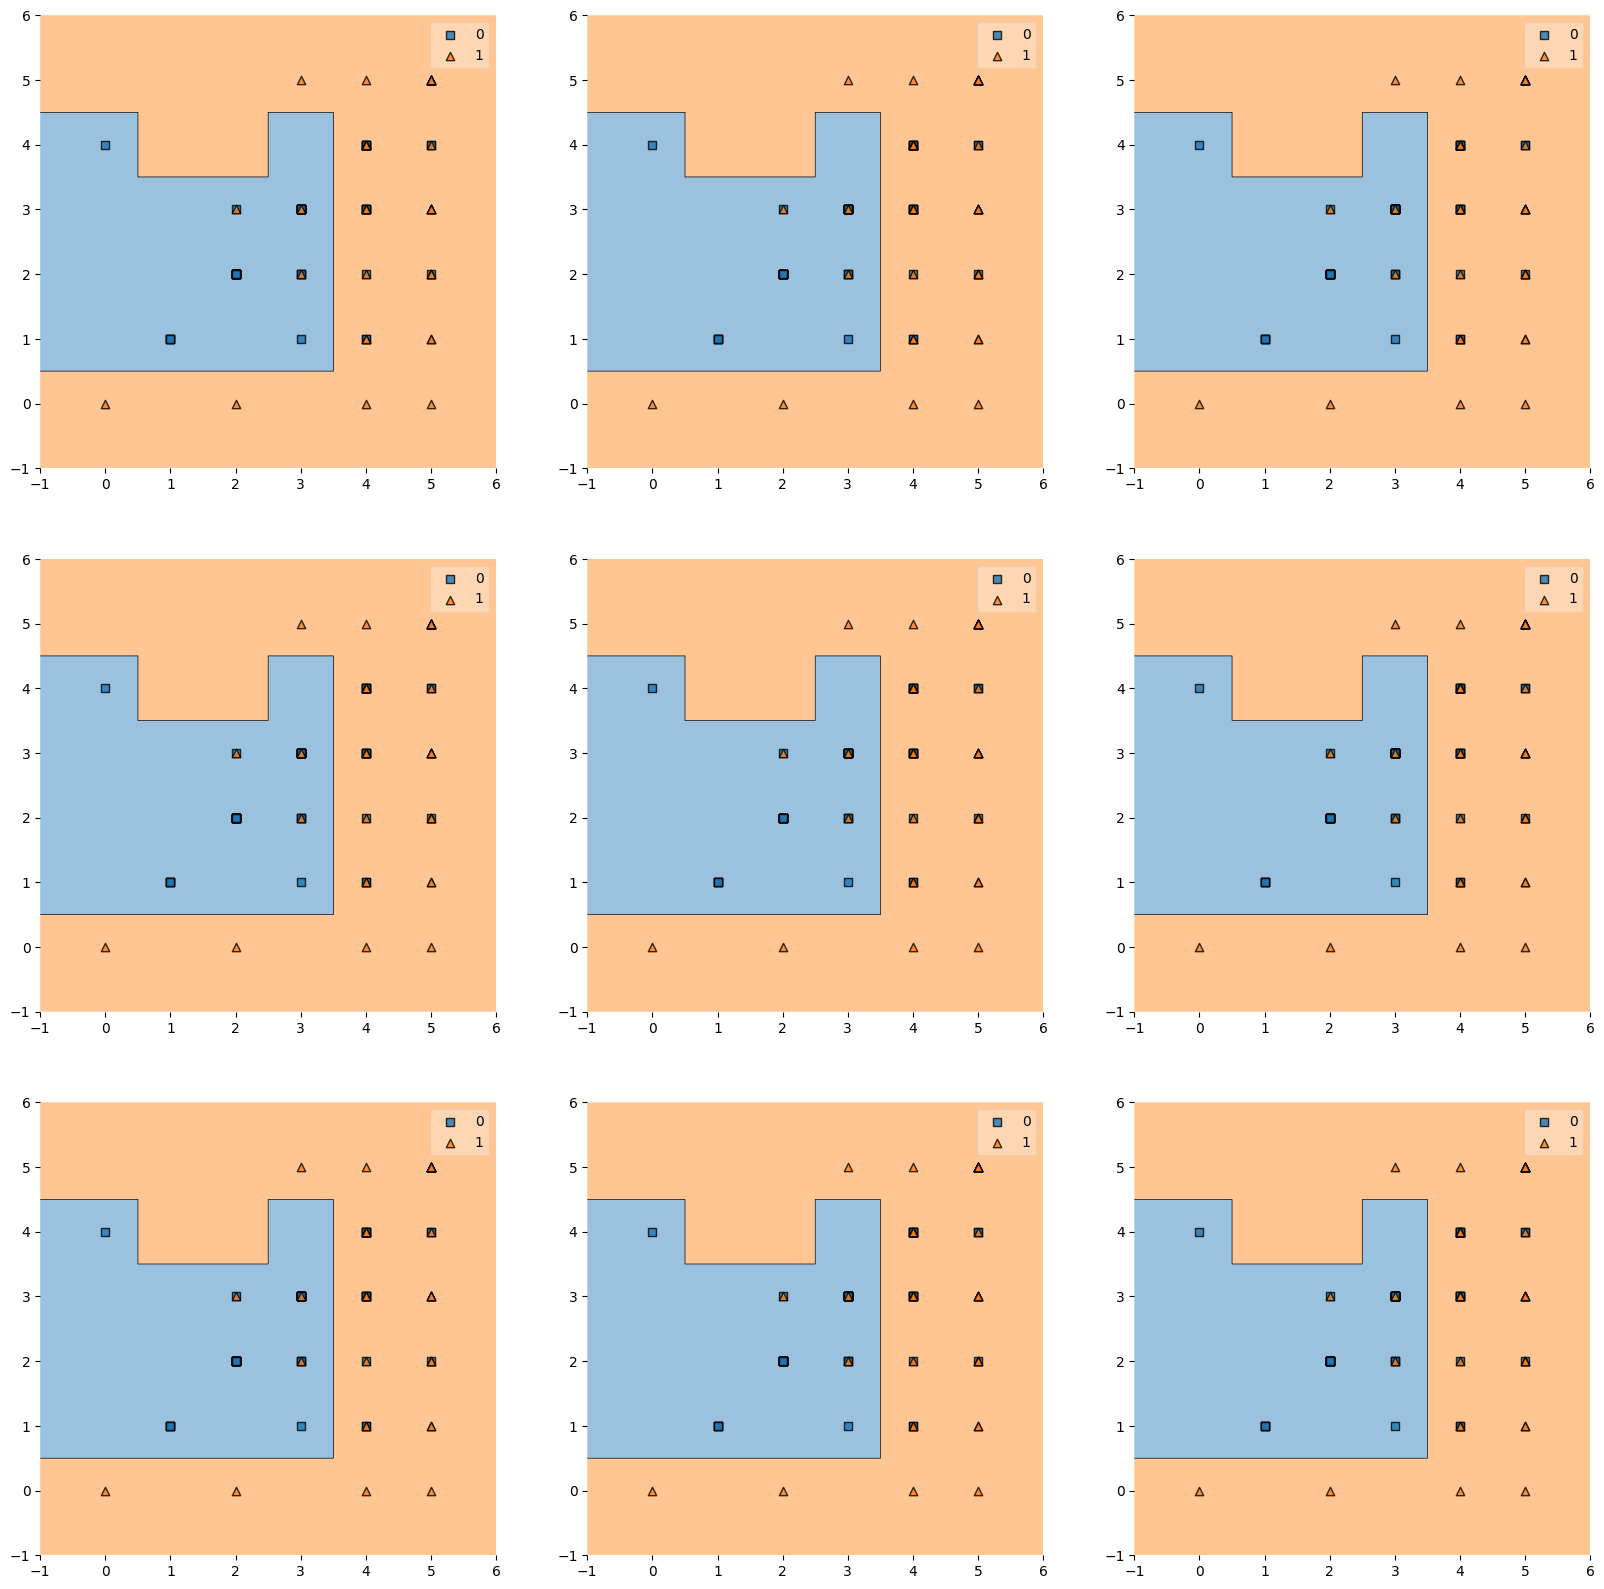

In [ ]:
# замените X_train_example на вашу переменную

X_train_example = X_train_top2.copy()

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
X_train_example

Online boarding  Inflight wifi service
0                  2.0                    2.0
1                  2.0                    0.0
2                  3.0                    3.0
3                  5.0                    4.0
4                  5.0                    5.0
...                ...                    ...
71390              1.0                    1.0
71391              2.0                    2.0
71392              4.0                    4.0
71393              4.0                    4.0
71394              3.0                    3.0

[71395 rows x 2 columns]

In [ ]:
%%time

# замените X_train_example на вашу переменную (ohe-encoded)
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 6.98 s, sys: 0 ns, total: 6.98 s
Wall time: 7.3 s


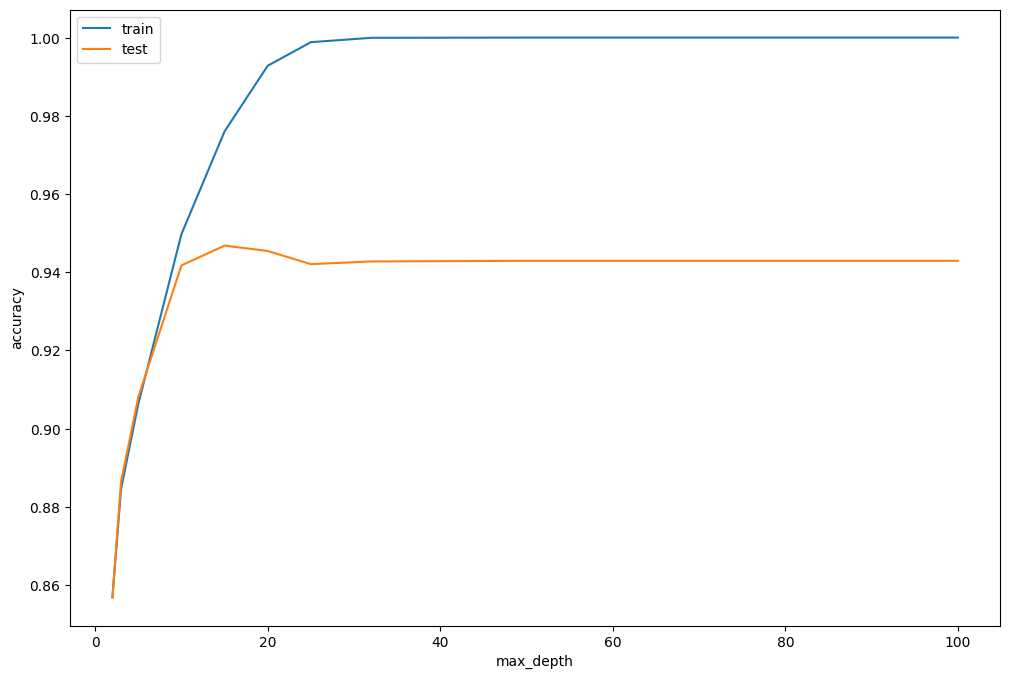

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
from sklearn.metrics import classification_report

param_grid = {
    'max_depth': [3, 5, 7, 10, None], # максимальное кол-во ветвлений
    'min_samples_split': [2, 5, 10], # минимальное количество объектов, чтобы разделиться
    'min_samples_leaf': [1, 2, 4], # минимальное количество объектов в листе
    'criterion': ['gini', 'entropy'], # критерий для разделения (gini или entropy)
    'max_features' : ["sqrt", "log2", None] # количество признаков, которые рассматриваются при каждом разделении в дереве решений
}

dt_3 = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_3, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность на кросс-валидации:", grid_search.best_score_)

# обучаем модель с лучшими параметрами и оцениваем на тестовых данных
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_val)

print("Точность на тестовых данных:", accuracy_score(y_val, y_pred))
print("Отчёт по классификации:\n", classification_report(y_val, y_pred))

KeyboardInterrupt: 

Качество улучшилось

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('dt_3.pickle', 'wb') as handle:
    pickle.dump(best_tree, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [17]:
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print("Точность на тестовых данных (accuracy):", accuracy_score(y_val, y_pred))
print("Отчёт по классификации:\n", classification_report(y_val, y_pred))

Точность на тестовых данных (accuracy): 0.9610631620243233
Отчёт по классификации:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     17383
           1       0.97      0.94      0.95     13205

    accuracy                           0.96     30588
   macro avg       0.96      0.96      0.96     30588
weighted avg       0.96      0.96      0.96     30588



### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

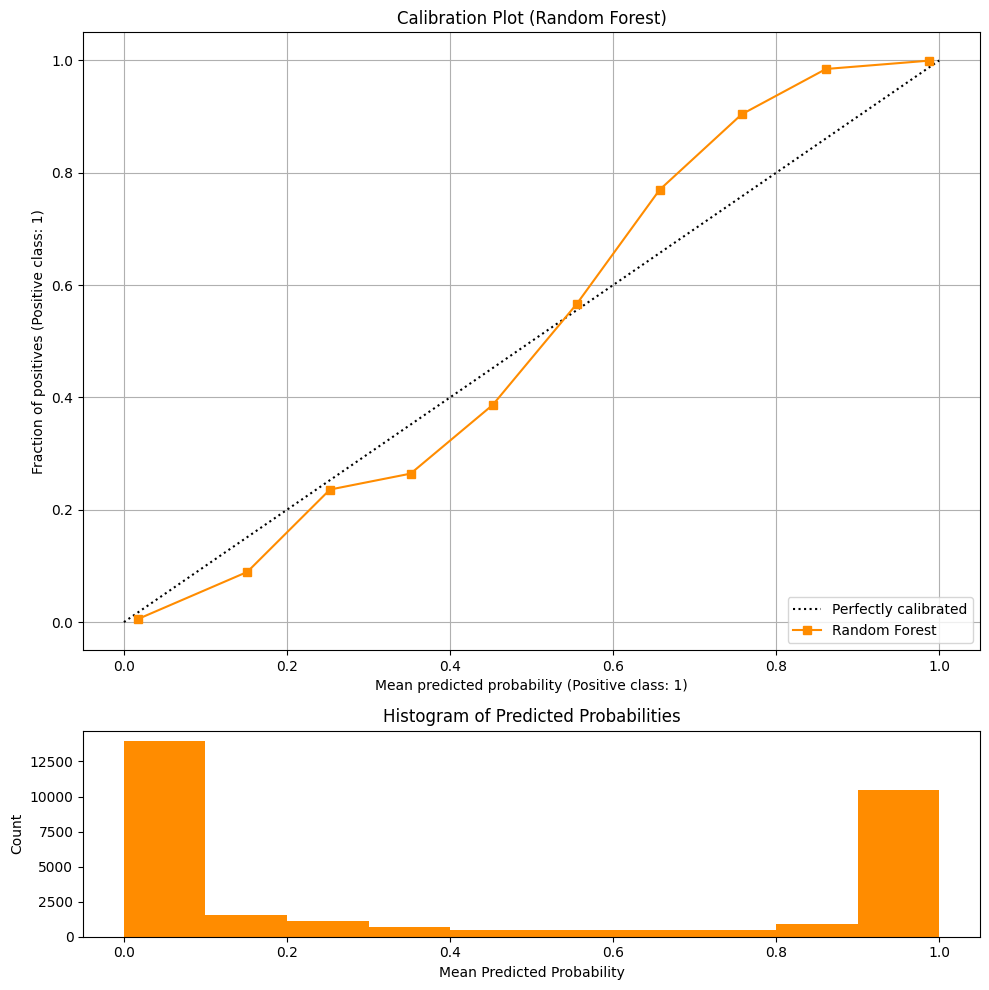

In [23]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

# задаём параметры для графика
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 1, height_ratios=[3, 1]) # 2 строки, 1 столбец

# строим калибровочную прямую
ax_calibration_curve = fig.add_subplot(gs[0])
display = CalibrationDisplay.from_estimator(
    rf,
    X_val,
    y_val,
    n_bins=10,  # количество бинов
    name="Random Forest",
    ax=ax_calibration_curve,
    color="darkorange",
)
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot (Random Forest)")

# гистограмма предсказанных вероятностей
ax_hist = fig.add_subplot(gs[1])
ax_hist.hist(
    display.y_prob, # предсказанные вероятности
    range=(0, 1),
    bins=10,
    color="darkorange",
    label="Random Forest",
)
ax_hist.set(title="Histogram of Predicted Probabilities", xlabel="Mean Predicted Probability", ylabel="Count")

plt.tight_layout()
plt.show()

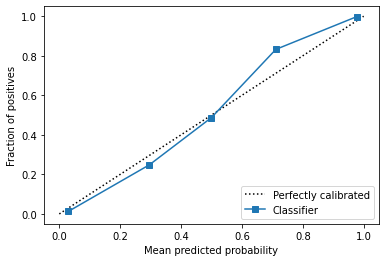

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Деревья плохо предсказывают вероятность, потому что по своей природе не очень подходят для этого. В каждом листе может быть несколько объектов и предсказанная вероятность это просто доля положительных классов в этом листе. Могут получаться ступенчатые результаты, которые будут плохо соответсвовать реальной вероятности.

Помимо этого, деревья очень склонны к переобучению. И переобученное дерево часто будет нам отдавать вероятности близкие к 1 или к 0 - то есть будет необоснованно "слишком сильно уверенно" в правильности ответа.

Если нам требуется определять вероятность чётко, то лучше отказаться от использования деревьев и воспользоваться изотонической логистической регрессией, которая лучше всего калибруется и показывает значения вероятности очень близкие или соответствующие реальной вероятности.

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


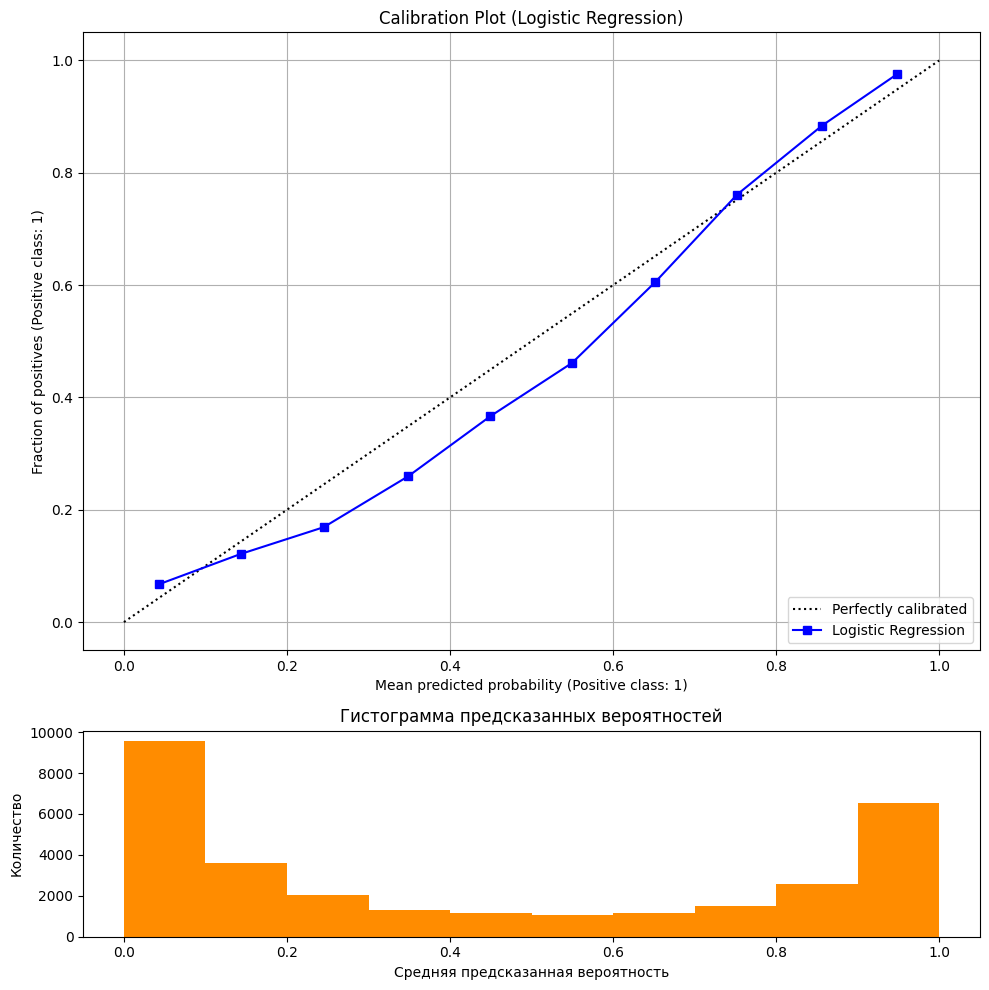

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 1, height_ratios=[3, 1])

# строим калибровочную прямую
ax_calibration_curve = fig.add_subplot(gs[0])
display = CalibrationDisplay.from_estimator(
    log_reg,
    X_val,
    y_val,
    n_bins=10,
    name="Logistic Regression",
    ax=ax_calibration_curve,
    color="blue",
)

# добавляем сетку
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot (Logistic Regression)")

# гистограмма предсказанных вероятностей
ax_hist = fig.add_subplot(gs[1])
ax_hist.hist(
    display.y_prob, # предсказанные вероятности
    range=(0, 1),
    bins=10,
    color="darkorange",
    label="Logistic Regression",
)
ax_hist.set(title="Гистограмма предсказанных вероятностей",
            xlabel="Средняя предсказанная вероятность", ylabel="Количество")

plt.tight_layout()
plt.show()

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms


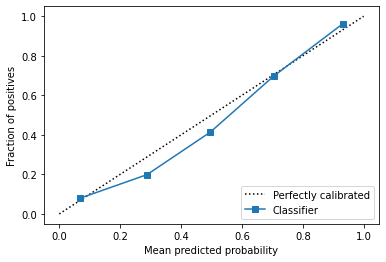

In [ ]:
# Ваш код здесь


Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Логистическая регрессия моделирует вероятность принадлежности к классу с помощью сигмоидной функции, которая принимает значения в диапазоне от 0 до 1. Калибровка встроена в модель так как предсказанные вероятности напрямую связаны с вероятностной интерпретацией модели. Логистическая регрессия также даёт гладкие вероятности в отличие от деревьев, которые даёт ступенчатые вероятности.

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

Text(0, 0.5, 'Количество образцов')

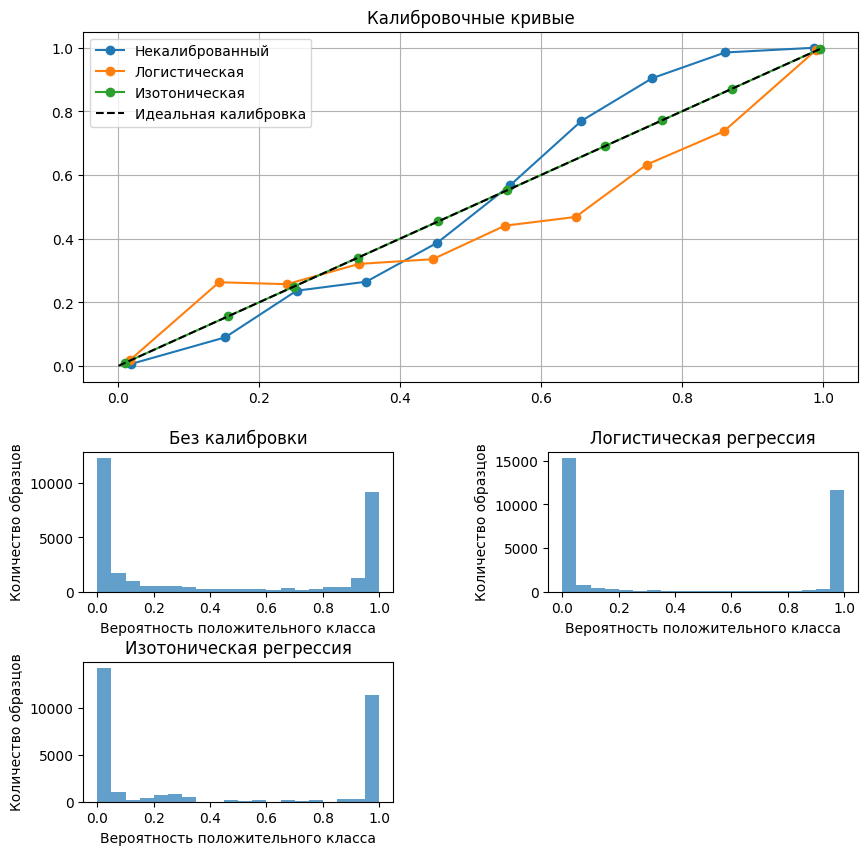

In [29]:
# NEW 2

from sklearn.frozen import FrozenEstimator
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# FrozenEstimator для предобученной модели ("prefit" is deprecated)
frozen_rf = FrozenEstimator(rf)

# калибровка с логистической регрессией
calibrated_rf_logistic = CalibratedClassifierCV(frozen_rf, method='sigmoid')
calibrated_rf_logistic.fit(X_val, y_val)  # используем только валидационные данные, чтобы избежать переобучения

# калибровка с изотонической регрессией
calibrated_rf_isotonic = CalibratedClassifierCV(frozen_rf, method='isotonic')
calibrated_rf_isotonic.fit(X_val, y_val)

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2, hspace=0.5, wspace=0.5)

# калибровочные кривые
ax_calibration = fig.add_subplot(gs[:2, :2])
for name, clf in [('Некалиброванный', frozen_rf),
                  ('Логистическая', calibrated_rf_logistic),
                  ('Изотоническая', calibrated_rf_isotonic)]:

    proba = clf.predict_proba(X_val)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_val, proba, n_bins=10)
    ax_calibration.plot(mean_predicted_value, fraction_of_positives, label=name, marker='o')

ax_calibration.plot([0, 1], [0, 1], "k--", label="Идеальная калибровка")
ax_calibration.set_title("Калибровочные кривые")
ax_calibration.grid(True)
ax_calibration.legend()

# распределение вероятностей без калибровки
ax_hist = fig.add_subplot(gs[2, 0])
probs = frozen_rf.predict_proba(X_val)[:, 1]
ax_hist.hist(probs, range=(0, 1), bins=20, density=False, alpha=0.7)
ax_hist.set_title('Без калибровки')
ax_hist.set_xlabel("Вероятность положительного класса")
ax_hist.set_ylabel("Количество объектов")

# распределение вероятностей с калибровкой логистической регрессией
ax_hist = fig.add_subplot(gs[2, 1])
probs = calibrated_rf_logistic.predict_proba(X_val)[:, 1]
ax_hist.hist(probs, range=(0, 1), bins=20, density=False, alpha=0.7)
ax_hist.set_title('Логистическая регрессия')
ax_hist.set_xlabel("Вероятность положительного класса")
ax_hist.set_ylabel("Количество объектов")

# распределение вероятностей с калибровкой изотонической регрессией
ax_hist = fig.add_subplot(gs[3, 0])
probs = calibrated_rf_isotonic.predict_proba(X_val)[:, 1]
ax_hist.hist(probs, range=(0, 1), bins=20, density=False, alpha=0.7)
ax_hist.set_title('Изотоническая регрессия')
ax_hist.set_xlabel("Вероятность положительного класса")
ax_hist.set_ylabel("Количество объектов")


# print("Точность на тестовых данных (accuracy):", accuracy_score(y_val, y_pred))

На графике калибровочных кривых видно, что модель рандомного леса с изотонической калибровкой очень точно повторяет диагональ идеальной калибровки. При этом калибровка с помощью логистической регрессии немного хуже корректирует смещение, возможно это вызвано спецификой данных, которые изначально имеют не очень похожую на сигмоиду форму. Гисторграммы показывают, что в большинстве случаев все модели дают очень уверенные прогнозы, поскольку большинство признаков расположены около значений 0 или 1.

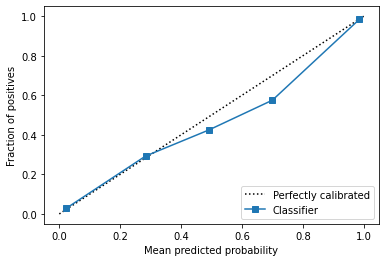

In [ ]:
# Ваш код здесь (Logreg)



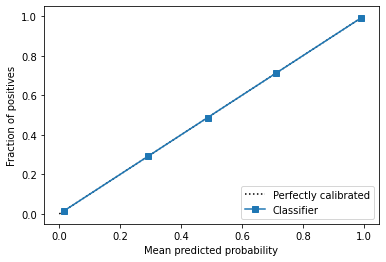

In [ ]:
# Ваш код здесь (isoreg)


### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

Калибровка Платта - метод, позволяющий откалибровать вероятности по сути накладывая сигмоиду поверх другой модели. Ссылка - https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti

### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [18]:
error_rf, bias_rf, var_rf = bias_variance_decomp(rf,
                                                 X_train.values,
                                                 y_train.values,
                                                 X_val.values,
                                                 y_val.values,
                                                 loss = '0-1_loss',
                                                 random_seed = 123,
                                                 num_rounds=20,
                                                 )
error_rf, bias_rf, var_rf

(0.040873872106708516, 0.03962338171832091, 0.008704393879952923)

**Показатели дерева решений:**
- Смещение: 0.0417483980646005
- Разброс: 0.04415457041977246

**Показатели рандомного леса:**
- Смещение: 0.03962338171832091
- Разброс: 0.008704393879952923

Смещение стало меньше, это улучшает качество прогнозов, усреднение предсказаний множества деревьев уменьшает чувствительность модели к шуму и выбросам в данных.

Также значительно уменьшился разброс, это более хороший результат чем у одного дерева решений, ансамбль деревьев в случайном лесе лучше улавливает сложные зависимости в данных, что снижает ошибку модели.

Эти результаты соответствуют теории.

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [21]:
# Ваш код здесь
error_lr, bias_lr, var_lr = bias_variance_decomp(log_reg,
                                                 X_train.values,
                                                 y_train.values,
                                                 X_val.values,
                                                 y_val.values,
                                                 loss = '0-1_loss',
                                                 random_seed = 123,
                                                 num_rounds=20,
                                                 )
error_lr, bias_lr, var_lr

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

(0.13192264940499543, 0.13194716882437557, 0.008331698705374656)

**Показатели дерева решений:**
- Смещение: 0.0417483980646005
- Разброс: 0.04415457041977246

**Показатели рандомного леса:**
- Смещение: 0.03962338171832091
- Разброс: 0.008704393879952923

**Показатели логистической регрессии:**
- Смещение: 0.13194716882437557
- Разброс: 0.008331698705374656

Логистическая регрессия имеет самое высокое смещение среди всех моделей, это указывает на её недообученность. Это связано с тем, что логистическая регрессия является линейной моделью, которая может плохо работать с нелинейными зависимостями в данных.

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [26]:
# сетка гиперпараметров с распределениями
param_dist = {
    'n_estimators': randint(50, 500), # число деревьев (целые числа)
    'max_depth': randint(5, 50), # глубина дерева (целые числа)
    'min_samples_split': uniform(0.01, 0.2), # минимальное число образцов для разделения (дроби)
    'max_features': ['sqrt', 'log2', None], # число признаков для разделения
    'bootstrap': [True, False], # использование бутстрэпа
    'criterion': ['gini', 'entropy'] # критерий разделения
}

rf = RandomForestClassifier(random_state=42)

# поиск
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50, # число итераций
    cv=5, # кросс-валидация
    scoring='accuracy', # метрика
    n_jobs=-1, # использовать все ядра
    random_state=42
)


random_search.fit(X_train[:5000], y_train[:5000])

print("Лучшие параметры:", random_search.best_params_)
print("Лучшая точность:", random_search.best_score_)

y_pred = random_search.best_estimator_.predict(X_val)
print("Точность на тесте:", accuracy_score(y_val, y_pred))

Лучшие параметры: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 34, 'max_features': 'log2', 'min_samples_split': 0.010155753168202867, 'n_estimators': 493}
Лучшая точность: 0.9339999999999999
Точность на тесте: 0.940401464626651


Лучшие параметры: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 34, 'max_features': 'log2', 'min_samples_split': 0.010155753168202867, 'n_estimators': 493}
Лучшая точность: 0.9339999999999999
Точность на тесте: 0.940401464626651

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [24]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

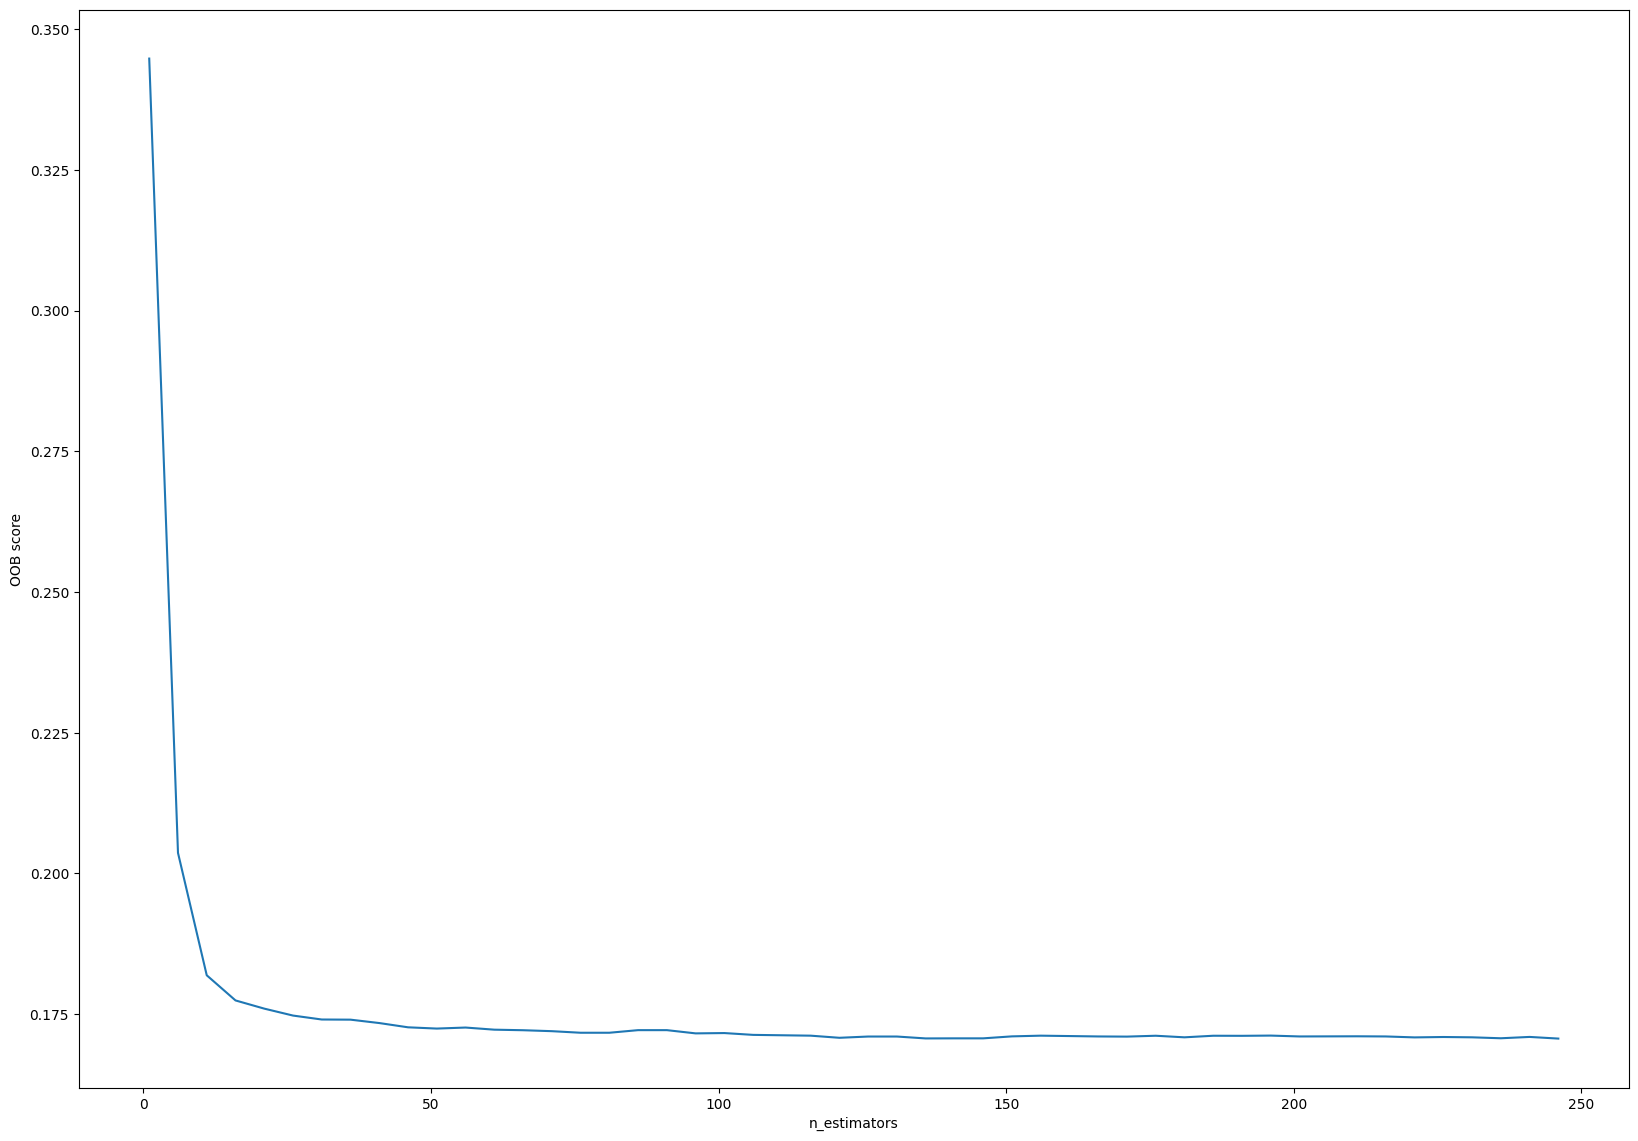

In [25]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [27]:
# Ваш код здесь
rand_search_best_rf = random_search.best_estimator_

rand_search_best_rf.feature_importances_

array([0.02435019, 0.02192878, 0.00660348, 0.00835055, 0.1649678 ,
       0.0117803 , 0.04324527, 0.00663347, 0.0071616 , 0.18810156,
       0.04317757, 0.06119406, 0.03820695, 0.04186267, 0.02698449,
       0.02209281, 0.02102702, 0.02477945, 0.0018012 , 0.03814018,
       0.11883926, 0.07429495, 0.00447642])

In [ ]:
# Ваш код здесь
# дерево решений
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# получаем "встроенную" важность признаков
feature_importances = dt.feature_importances_

# DataFrame для удобства визуализации
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# график топ 20 самых важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances in Decision Tree', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

In [ ]:
# рандомный лес
# получаем "встроенную" важность признаков
feature_importances = dt.feature_importances_

# DataFrame для удобства визуализации
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# график топ 20 самых важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances in Random Forest', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [28]:
from joblib import dump

dump(rand_search_best_rf, 'rand_search_best_rf.joblib')

['rand_search_best_rf.joblib']

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

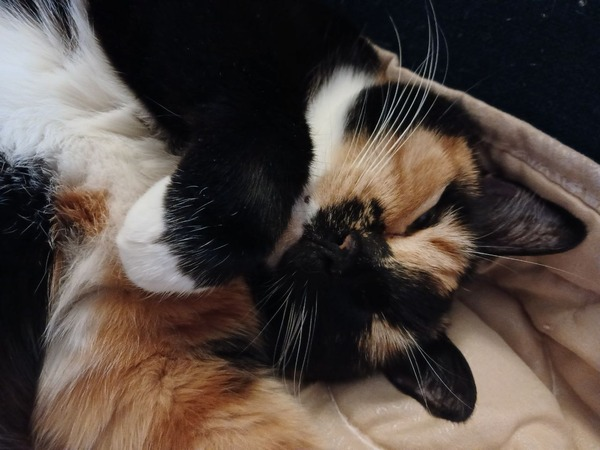

Предположу, что кот живёт у @onthebox

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Задания интересные, практика помогает не забыть что слушал на лекции. Сложность относительна, по моим ощущениям 8 из 10, я потратил несколько дней, делая в несколько заходов по несколько заданий. Возникли сложности с пониманием калибровки модели, но вроде как разобрался.